<a href="https://colab.research.google.com/github/Zinni98/Sentiment-analysis-project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Polarity Classification

In [1]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [2]:
import sys
sys.path.append("/content/gdrive/My Drive/nlu-project")

In [3]:
import nltk
import torch
from nltk.corpus import movie_reviews
import numpy as np


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

In [4]:
nltk.download("punkt")
nltk.download("movie_reviews")
nltk.download("subjectivity")
nltk.download("stopwords")
nltk.download("sentiwordnet")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package subjectivity to /root/nltk_data...
[nltk_data]   Unzipping corpora/subjectivity.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [5]:
from nltk.corpus import stopwords
import re
import spacy
from abc import ABC, abstractmethod

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from nltk.sentiment.util import mark_negation

from nltk.corpus import subjectivity


CONTRACTION_MAP =  {"ain't": "is not",
                        "aren't": "are not",
                        "can't": "cannot",
                        "can't've": "cannot have",
                        "'cause": "because",
                        "could've": "could have",
                        "couldn't": "could not",
                        "couldn't've": "could not have",
                        "didn't": "did not",
                        "doesn't": "does not",
                        "don't": "do not",
                        "hadn't": "had not",
                        "hadn't've": "had not have",
                        "hasn't": "has not",
                        "haven't": "have not",
                        "he'd": "he would",
                        "he'd've": "he would have",
                        "he'll": "he will",
                        "he'll've": "he he will have",
                        "he's": "he is",
                        "how'd": "how did",
                        "how'd'y": "how do you",
                        "how'll": "how will",
                        "how's": "how is",
                        "i'd": "i would",
                        "i'd've": "i would have",
                        "i'll": "i will",
                        "i'll've": "i will have",
                        "i'm": "i am",
                        "i've": "i have",
                        "isn't": "is not",
                        "it'd": "it would",
                        "it'd've": "it would have",
                        "it'll": "it will",
                        "it'll've": "it will have",
                        "it's": "it is",
                        "let's": "let us",
                        "ma'am": "madam",
                        "mayn't": "may not",
                        "might've": "might have",
                        "mightn't": "might not",
                        "mightn't've": "might not have",
                        "must've": "must have",
                        "mustn't": "must not",
                        "mustn't've": "must not have",
                        "needn't": "need not",
                        "needn't've": "need not have",
                        "o'clock": "of the clock",
                        "oughtn't": "ought not",
                        "oughtn't've": "ought not have",
                        "shan't": "shall not",
                        "sha'n't": "shall not",
                        "shan't've": "shall not have",
                        "she'd": "she would",
                        "she'd've": "she would have",
                        "she'll": "she will",
                        "she'll've": "she will have",
                        "she's": "she is",
                        "should've": "should have",
                        "shouldn't": "should not",
                        "shouldn't've": "should not have",
                        "so've": "so have",
                        "so's": "so as",
                        "that'd": "that would",
                        "that'd've": "that would have",
                        "that's": "that is",
                        "there'd": "there would",
                        "there'd've": "there would have",
                        "there's": "there is",
                        "they'd": "they would",
                        "they'd've": "they would have",
                        "they'll": "they will",
                        "they'll've": "they will have",
                        "they're": "they are",
                        "they've": "they have",
                        "to've": "to have",
                        "wasn't": "was not",
                        "we'd": "we would",
                        "we'd've": "we would have",
                        "we'll": "we will",
                        "we'll've": "we will have",
                        "we're": "we are",
                        "we've": "we have",
                        "weren't": "were not",
                        "what'll": "what will",
                        "what'll've": "what will have",
                        "what're": "what are",
                        "what's": "what is",
                        "what've": "what have",
                        "when's": "when is",
                        "when've": "when have",
                        "where'd": "where did",
                        "where's": "where is",
                        "where've": "where have",
                        "who'll": "who will",
                        "who'll've": "who will have",
                        "who's": "who is",
                        "who've": "who have",
                        "why's": "why is",
                        "why've": "why have",
                        "will've": "will have",
                        "won't": "will not",
                        "won't've": "will not have",
                        "would've": "would have",
                        "wouldn't": "would not",
                        "wouldn't've": "would not have",
                        "y'all": "you all",
                        "y'all'd": "you all would",
                        "y'all'd've": "you all would have",
                        "y'all're": "you all are",
                        "y'all've": "you all have",
                        "you'd": "you would",
                        "you'd've": "you would have",
                        "you'll": "you will",
                        "you'll've": "you will have",
                        "you're": "you are",
                        "you've": "you have",
                    }

class PipelineElement(ABC):
  """
  Abstract class for the definition of each element
  """
  def __init__(self):
    pass

  @abstractmethod
  def __call__(self):
    pass


class Pipeline():
  """
  Pipeline class which collects pipeline elements (in the order given).
  This class implements __call__ method so it is a callable.
  When called it applies all the PipelineElements in the order given.
  """
  def __init__(self, *args):
    """
    Parameters
    ----------
    *args
      PipelineElements
    """
    self.pipeline = []
    for arg in args:
      self.add_pipeline_element(arg)

  def add_pipeline_element(self, element: PipelineElement, position: int = None):
    """
    Adds a new pipeline element to the pipeline
    
    Parameters
    ----------
    element : PipelineElement
      the element to be added to the pipeline
    
    position : int
      position in the pipeline where the element should be added
      position ranges from 0 to (n_elements - 1) where n_elements
      is the number of elements in the pipeline.
    Raises
    ------
    TypeError
      If the type of element is not PipelineElement
    """
    if not issubclass(type(element), PipelineElement):
      raise TypeError("Wrong element type, only Pipeline elements subclasses can be added")
    if position:
      if position >= len(self.pipeline):
        raise ValueError("position index exceeds the lenght of the pipeline")
      self.pipeline.insert(position, element)
    else:
      self.pipeline.append(element)
  
  def pipe(self, corpus):
    """
    Applies each element in the pipeline

    Parameters
    ----------
    corpus : list
      list containing each document in the corpus
    """
    for el in self.pipeline:
        corpus = el(corpus)
    return corpus
  
  def get_elements(self):
    """
    Gives elements of the pipeline with respective index indicateing the order
    in which elements are called

    Returns
    -------
    dict
      Where the key indicates the position of each element in the pipeline
      (i.e. execution order, where 0 is the first element of the pipeline
      being called) and the value indicates the actual element.
    """
    res = {}
    for idx, el in pipeline:
      res[idx] = el
    return res
 
  def __call__(self, *args):
      if args[0] == None:
          raise ValueError("Need a corpus as argument")
      corpus = args[0]
      return self.pipe(corpus)
  
  def __len__(self):
    return len(pipeline)
        
# Flattened Elements

class UnderscoreRemoverFlat(PipelineElement):
  """
  Assumes the corpus is flat (i.e. the corpus is a list of documents,
  each document is a list of words, therefore the document is not
  divided in sentences)
  """
  def __init__(self):
    super(UnderscoreRemoverFlat, self).__init__()

  def remove_underscores(self, corpus):
    """
    Solves the problem where some of the words are surrounded by underscores
    (e.g. "_hello_")

    Parameters
    ----------
    corpus : list of list of list
      corpus to be processed
    """
    for doc in corpus:
        for idx, word in enumerate(doc):
            if "_" in word:
                cleaned_word = self._clean_word(word)
                doc[idx] = cleaned_word
    return corpus


  def _clean_word(self, word: str):
    word = word.replace("_", " ")
    # in order to remove spaces before and after the word
    word = word.split()
    word = " ".join(word)
    return word

  def __call__(self, corpus):
    return self.remove_underscores(corpus)

class CharacterRepetitionRemoverFlat(PipelineElement):
  """
  Reduces repetition to two characters 
  for alphabets and to one character for punctuations.

  Examples
  --------
  >>> reducing_character_repetitions([["Realllllllllyyyyy,        Greeeeaaaatttt   !!!!?....;;;;:)"]])
  Really, Great !?.;:)
  """
  def __init__(self):
    super(CharacterRepetitionRemoverFlat, self).__init__()

  def reducing_character_repetitions(self, corpus):
    """
    Parameters
    ----------
      corpus : list of list of list
    Returns
    -------
    list of list
      Formatted text with alphabets repeating to 
      two characters & punctuations limited to one repetition 

    """
    new_corpus = []
    for doc in corpus:
        new_doc = [self._clean_repetitions(w) for w in doc]
        new_corpus.append(new_doc)
    return new_corpus

  # inspired by https://towardsdatascience.com/cleaning-preprocessing-text-data-by-building-nlp-pipeline-853148add68a
  def _clean_repetitions(self, word):
    # Pattern matching for all case alphabets
    pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)

    # Limiting all the repetitions to two characters.
    formatted_text = pattern_alpha.sub(r"\1\1", word) 

    # Pattern matching for all the punctuations that can occur
    pattern_punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')

    # Limiting punctuations in previously formatted string to only one.
    combined_formatted = pattern_punct.sub(r'\1', formatted_text)

    # The below statement is replacing repetitions of spaces that occur more than two times with that of one occurrence.
    final_formatted = re.sub(' {2,}',' ', combined_formatted)
    return final_formatted

  def __call__(self, corpus):
    return self.reducing_character_repetitions(corpus)

class ApostrophesMergerFlat(PipelineElement):
  """
  Merges words like "don't" which in the original corpus are
  separated like: ["don", "'", "t"]

  Examples
  --------
  >>> am = ApostrophesMergerFlat()
  >>> am([["I", "'", "ve", "a", "pair", "of", "shoes"]])
  [["I've", "a", "pair", "of", "shoes"]]
  """

  def __init__(self):
    super(ApostrophesMergerFlat, self).__init__()

  def merge_apostrophes(self, corpus):
    """
    Parameters
    ----------
    corpus : list of list of list

    Returns
    -------
    list of list
      Formatted text where contractions are merged into one single word
    
    """
    new_corpus = []
    for doc in corpus:
      indexes = self._get_neg_indexes(doc)
      for el in indexes:
        doc[el[0]:el[1]] = ["".join(doc[el[0]:el[1]])]
      new_corpus.append(doc)
    return new_corpus

  def _get_neg_indexes(self, sent):

    # s not considered because contraction can be either "is", genitive or "has"
    contr = ["t", "ve", "re", "ll", "d", "all", "y", "cause", "m", "clock", "am"] #, "s"]
    indexes = []
    for idx, word in enumerate(sent):
      # Try-except to avoid out of range indexes (there can be some "'" a the beginning or end of the phrase)
      try:
        if word=="'" and sent[idx+1] in contr:
          indexes.append((idx-1,idx+2))
      except:
        pass
    return indexes
  
  def __call__(self, corpus):
    return self.merge_apostrophes(corpus)


class ContractionCleanerFlat(PipelineElement):
  """
  Clean all contractions by using a predifined contraction map

  Example
  -------
  >>> cc = ContractionCleanerFlat
  """
  def __init__(self):
    super(ContractionCleanerFlat, self).__init__()

  def clean_contractions(self, corpus):
    """
    Parameters
    ----------
    corpus : list of list of list

    Returns
    -------
    list of list
      Formatted text where contractions are merged into one single word

    """
    new_corpus = []
    for doc in corpus:
      new_doc = []
      for word in doc:
        try:
            correct = CONTRACTION_MAP[word]
            correct = correct.split()
            new_doc += correct
        except:
            new_doc.append(word)
      new_corpus.append(new_doc)
    return new_corpus

  def __call__(self, corpus):
    return self.clean_contractions(corpus)

class SpecialCharsCleanerFlat(PipelineElement):
  """
  Removes all special characters which are not part of
  the folllowing regex pattern: "[^a-zA-Z0-9:€$-,%?!]+"
  """
  def __init__(self):
    super(SpecialCharsCleanerFlat, self).__init__()

  def clean_special_chars(self, corpus):
    new_corpus = [[self._clean_special_word(w) for w in doc] for doc in corpus]
    new_corpus = [[w for w in doc] for doc in corpus]
    return new_corpus
    
  def _clean_special_word(self, word):
    # The formatted text after removing not necessary punctuations.
    formatted_text = re.sub(r"[^a-zA-Z0-9:€$-,%?!]+", '', word) 
    # In the above regex expression,I am providing necessary set of punctuations that are frequent in this particular dataset.
    return formatted_text
  
  def __call__(self, corpus):
    return self.clean_special_chars(corpus)

class StopWordsRemoverFlat(PipelineElement):
  """
  Removes stopwords from the document.
  It doesn't remove stopwords that contain negations
  """

  def __init__(self):
    super(StopWordsRemoverFlat, self).__init__()

  def remove_stop_words(self, corpus):
    stops = stopwords.words("english")
    stops = [word for word in stops if "'t" not in word or "not" not in word]
    return [[word for word in doc if word not in stops] for doc in corpus]

  def __call__(self, corpus):
    return self.remove_stop_words(corpus)


################################################################################

# Non-flattened elements
"""
These items are the same as before with the only difference that now
the assumption is that the corpus is not flattened, so each document
is composed by serveral separated sentences:

Example
-------

"""
class UnderscoreRemover(PipelineElement):

  def __init__(self):
    super(UnderscoreRemover, self).__init__()

  def remove_underscores(self, corpus):
    """
    Solves the problem where some of the words are surrounded by underscores
    (e.g. "_hello_")
    """
    for doc in corpus:
      for sent_idx, sent in enumerate(doc):
        new_sent = []
        for idx, word in enumerate(sent):
          if "_" in word:
            cleaned_word = self._clean_word(word)
            new_sent += cleaned_word
          else:
            new_sent.append(word)
        if len(new_sent) > 0:
          doc[sent_idx] = new_sent
    return corpus

  def _clean_word(self, word: str):
    word = word.replace("_", " ")
    # remove spaces before and after the word
    word = word.split()
    return word

  def __call__(self, corpus):
    return self.remove_underscores(corpus)



class CharacterRepetitionRemover(PipelineElement):
  def __init__(self):
    super(CharacterRepetitionRemover, self).__init__()

  def reducing_character_repetitions(self, corpus):
      new_corpus = [[[self._clean_repetitions(w) for w in sent] for sent in doc] for doc in corpus]
      return new_corpus
  
  # inspired by https://towardsdatascience.com/cleaning-preprocessing-text-data-by-building-nlp-pipeline-853148add68a
  def _clean_repetitions(self, word):
    """
    This Function will reduce repetition to two characters 
    for alphabets and to one character for punctuations.

    Parameters
    ----------
        word: str                
    Returns
    -------
    str
        Finally formatted text with alphabets repeating to 
        one characters & punctuations limited to one repetition 
        
    Example:
    Input : Realllllllllyyyyy,        Greeeeaaaatttt   !!!!?....;;;;:)
    Output : Really, Great !?.;:)

    """
    # Pattern matching for all case alphabets
    pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)

    # Limiting all the repetitions to two characters.
    # MODIFIED: keep only one repetition of the character
    formatted_text = pattern_alpha.sub(r"\1\1", word) 

    # Pattern matching for all the punctuations that can occur
    pattern_punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')

    # Limiting punctuations in previously formatted string to only one.
    combined_formatted = pattern_punct.sub(r'\1', formatted_text)

    # The below statement is replacing repetitions of spaces that occur more than two times with that of one occurrence.
    final_formatted = re.sub(' {2,}',' ', combined_formatted)
    return final_formatted
  
  def __call__(self, corpus):
    return self.reducing_character_repetitions(corpus)


class ApostrophesMerger(PipelineElement):
  def __init__(self):
    super(ApostrophesMerger, self).__init__()

  def merge_apostrophes(self, corpus):
    new_corpus = []
    for doc in corpus:
      new_doc = []
      for sent in doc:
        indexes = self._get_neg_indexes(sent)
        for el in indexes:
          sent[el[0]:el[1]] = ["".join(sent[el[0]:el[1]])]
        new_doc.append(sent)
      new_corpus.append(new_doc)
    return new_corpus

  def _get_neg_indexes(self, sent):
    contr = ["t", "ve", "re", "ll", "d", "all", "y", "cause", "m", "clock", "am"]#, "s"]
    indexes = []
    for idx, word in enumerate(sent):
      # Try-except to avoid out of range indexes (there can be some "'" a the beginning or end of the phrase)
      try:
        if word=="'" and sent[idx+1] in contr:
          indexes.append((idx-1,idx+2))
      except:
        pass
      return indexes
  
  def __call__(self, corpus):
    return self.merge_apostrophes(corpus)


class ContractionCleaner(PipelineElement):

  def __init__(self):
    super(ContractionCleaner, self).__init__()

  def clean_contractions(self, corpus):
    new_corpus = []
    for doc in corpus:
      new_doc = []
      for sent in doc:
        new_sent = []
        for word in sent:
          try:
            correct = CONTRACTION_MAP[word]
            correct = correct.split()
            new_sent += correct
          except:
            new_sent.append(word)
        new_doc.append(new_sent)
      new_corpus.append(new_doc)
    return new_corpus

  def __call__(self, corpus):
    return self.clean_contractions(corpus)


class SpecialCharsCleaner(PipelineElement):
  def __init__(self):
    super(SpecialCharsCleaner, self).__init__()
  
  def clean_special_chars(self, corpus):
      for idx_doc, doc in enumerate(corpus):
        for sent_idx, sent in enumerate(doc):
          new_sent = []
          for word_idx, word in enumerate(sent):
            new_word = self._clean_special_word(word)
            if new_word != " ":
              new_sent += new_word.split()
          if len(new_sent) > 0:
            doc[sent_idx] = new_sent
      return corpus
    
  def _clean_special_word(self, word):
    # The formatted text after removing not necessary punctuations.
    formatted_text = re.sub(r"[^a-zA-Z0-9:€$-,%?!]+", ' ', word) 
    return formatted_text
  
  def __call__(self, corpus):
    return self.clean_special_chars(corpus)

class StopWordsRemover(PipelineElement):
  def __init__(self):
    super(StopWordsRemover, self).__init__()

  def remove_stop_words(self, corpus):
    stops = stopwords.words("english")
    # Don't want to remove stop words associated with negations
    stops = [word for word in stops if "'t" not in word or "not" not in word]
    return [[[word for word in sent if word not in stops] for sent in doc] for doc in corpus]

  def __call__(self, corpus):
    return self.remove_stop_words(corpus)

class ShallowObjectiveSentsRemover(PipelineElement):
  def __init__(self, threshold = .5, clf = None):
    self.vectorizer = CountVectorizer()
    if clf == None:
      self.classifier = MultinomialNB()
      self.best_estimator = self._train()
    else:
      self.classifier = clf
      self.best_estimator = self.classifier
  
  def _train(self):
    subj = [sent for sent in subjectivity.sents(categories = 'subj')]
    obj = [sent for sent in subjectivity.sents(categories = 'obj')]

    corpus = [self.neg_marking_list2str(d) for d in subj] + [self.neg_marking_list2str(d) for d in obj]
    vectors = self.vectorizer.fit_transform(corpus)
    labels = np.array([1] * len(subj) + [0] * len(obj))
    scores = cross_validate(self.classifier, vectors, labels, cv=StratifiedKFold(n_splits=10) , scoring=['accuracy'], return_estimator=True)
    estimator = scores["estimator"][scores["test_accuracy"].argmax()]
    return estimator

  def neg_marking_list2str(self, sent):
    # takes the doc and produces a single list
    # negates the whole document
    negated_doc = mark_negation(sent, double_neg_flip=True)
    return " ".join([w for w in negated_doc])
    

  def remove_objective_sents(self, corpus):
    transformed_corpus = [[self.vectorizer.transform([self.neg_marking_list2str(sent)]) for sent in doc] for doc in corpus]
    res = [[corpus[doc_idx][sent_idx] for sent_idx, sent in enumerate(doc) if self.best_estimator.predict(sent).item()]
           for doc_idx, doc in enumerate(transformed_corpus)]
    return res
  
  def __call__(self, corpus):
    return self.remove_objective_sents(corpus)

class Flattener(PipelineElement):
  def __init__(self):
    super().__init__()
  
  def flatten(self, corpus):
    corpus = [[w for sent in doc for w in sent] for doc in corpus]
    return corpus

  def __call__(self, corpus):
    return self.flatten(corpus)


### Corpus class
I'm going to create a class for the representation of the corpus in order to have a self contained way to have all the information about corpus attributes (vocab, words ....)

In [6]:
class CorpusBase(ABC):
  """
  Base class for representing corpus
  """
  def __init__(self, preprocess_pipeline = None, corpus = None):
    self.embedding_matrix = None

    if corpus == None:
      self.unprocessed_corpus, self.labels = self._get_corpus()
    else:
      self.unprocessed_corpus, self.labels = corpus[0], corpus[1]

    self.pipeline = preprocess_pipeline
    self.processed_corpus = self._preprocess()

    self.vocab = self._create_vocab()
  
  @abstractmethod
  def get_indexed_corpus(self):
    """
    Method to return the corpus where each word is replaced
    with the index of the word itself in the vocabulary.
    """
    pass

  def _preprocess(self):
    """
    Preprocess the unprocessed corpus using the pipeline object, if it is not None.
    Otherwise, return the unprocessed corpus as it is.

    Returns
    -------
      The processed corpus.
    """
    if self.pipeline != None:
      return self.pipeline(self.unprocessed_corpus)
    else:
      return self.unprocessed_corpus
  

  def _get_corpus(self):
    """
    Get the movie reviews corpus and their labels.

    Returns
    -------
    tuple
      A tuple containing the list of movie reviews and the list of labels.
    """
    mr = movie_reviews
    neg = mr.paras(categories = "neg")
    pos = mr.paras(categories = "pos")
    labels = [0] * len(neg) + [1] * len(pos)
    return neg + pos, labels
    
  def get_embedding_matrix(self, embedding, embedding_dim):
    """
    Create an embedding matrix from a given embedding dictionary.

    Parameters
    ----------
    embedding : dict
        A dictionary mapping vocabulary items to their embeddings.
    embedding_dim : int
        The dimensionality of the embeddings.

    Returns
    -------
    torch.Tensor
      A matrix of size (len(self.vocab), embedding_dim) containing the embeddings for the vocabulary items.
    """
    # avoid recomputing embedding matrix multiple times
    if self.embedding_matrix != None:
      return self.embedding_matrix
    matrix_length = len(self.vocab)
    embedding_matrix = np.zeros((matrix_length, embedding_dim))
    # If I use torch.zeros directly it crashes (don't know why)
    embedding_matrix = torch.from_numpy(embedding_matrix.copy())
    null_embedding = torch.tensor([0.0]*embedding_dim)
    for idx, key in enumerate(self.vocab.keys()):
      if torch.equal(embedding[key], null_embedding):
        embedding_matrix[idx] = torch.randn(embedding_dim)
      else:
        embedding_matrix[idx] = embedding[key]
    
    self.embedding_matrix = embedding_matrix
    return embedding_matrix

  def _create_vocab(self):
    """
    Create a vocabulary from the processed corpus.

    Returns
    -------
    dict
      A dictionary mapping vocabulary items to their frequencies in the corpus.
    """
    vocab = dict()
    corpus_words = [w for doc in self.processed_corpus for sent in doc for w in sent]
    for word in corpus_words:
      try:
        vocab[word] += 1
      except:
        vocab[word] = 1
    return vocab

  def __len__(self):
    return len(self.processed_corpus)


In [7]:
from nltk.corpus import movie_reviews
import numpy as np
import torch
import spacy


class MovieReviewsCorpus(CorpusBase):
  def __init__(self, preprocess_pipeline = None):
    """
    Parameters
    ----------
    preprocess_pipeline
      pipeline that should be applied to the corpus.
    
    """
    # Corpus as list of documents. Documents as list of sentences. Sentences as list of tokens
    super().__init__(preprocess_pipeline)
    # Flattening corpus
    self.processed_corpus = [[w for sent in doc for w in sent] for doc in self.processed_corpus]
  
  def get_subset_indexed_corpus(self, indexes):
    reduced_corpus = [self.processed_corpus[idx] for idx in indexes]
    labels = [self.labels[idx] for idx in indexes]
    vocab = {}
    for idx, key in enumerate(self.vocab.keys()):
      vocab[key] = idx

    indexed_corpus = [torch.tensor([torch.tensor(vocab[w], dtype=torch.int32) for w in doc]) for doc in reduced_corpus]
    return reduced_corpus, indexed_corpus, labels
  
  def get_indexed_corpus(self):
    """

    Returns the corpus as tensor of indexes.

    Returns
    -------
    list(torch.tensor(torch.tensor))
      The corpus represented as indexes corresponding to each word
    
    list
      labels associated with each document
    """
    vocab = {}
    for idx, key in enumerate(self.vocab.keys()):
      vocab[key] = idx

    indexed_corpus = [torch.tensor([torch.tensor(vocab[w], dtype=torch.int32) for w in doc]) for doc in self.processed_corpus]
    return indexed_corpus, self.labels



In [ ]:
class SubjectivityCorpus(CorpusBase):
  def __init__(self, preprocess_pipeline = None):
    super().__init__(preprocess_pipeline)


  def _get_corpus(self):
    subj = [sent for sent in subjectivity.sents(categories = 'subj')]
    obj = [sent for sent in subjectivity.sents(categories = 'obj')]
    labels = [1] * len(subj) + [0] * len(obj)
    return subj + obj, labels

  def _create_vocab(self):
      vocab = dict()
      corpus_words = [w for sent in self.processed_corpus for w in sent]
      vocab_index = 0
      for word in corpus_words:
        try:
          vocab[word]
        except:
          vocab[word] = vocab_index
          vocab_index += 1
      return vocab

  
  def get_indexed_corpus(self):
      """
      Returns
      -------
      Dictionary
          Containing correspondences word -> index
      
      list(list(torch.tensor))
          The corpus represented as indexes corresponding to each word
      """
      vocab = {}
      for idx, key in enumerate(self.vocab.keys()):
          vocab[key] = idx
      
      indexed_corpus = [torch.tensor([vocab[word] for word in sent]) for sent in self.processed_corpus]
      return indexed_corpus, self.labels



In [8]:
from torch.utils.data import Dataset
from torchtext.vocab import GloVe

class MovieReviewsDataset(Dataset):
  def __init__(self, raw_dataset):
    super().__init__()
    self.corpus = raw_dataset[0]
    self.targets = raw_dataset[1]

  def __len__(self):
    return len(self.corpus)
  
  def __getitem__(self, index):
    item = self.corpus[index]
    label = self.targets[index]
    return (item, label)

### Create the model class
Let's first try with a simple BiLSTM

In [9]:
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_packed_sequence
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torch

class BiLSTM(nn.Module):
  def __init__(self, embedding_matrix = None, device = "cuda", input_size = 300, hidden_size = 128, output_size = 2):
    super().__init__()
    self.hidden_size = hidden_size
    self.device = device
    if embedding_matrix != None:
      self.embedding = self.create_embedding_layer(embedding_matrix)
    else:
      self.embedding = None
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True, bidirectional=True)
    self.fc = nn.Sequential(nn.ReLU(),
                            nn.BatchNorm1d(hidden_size*2, eps = 1e-08),
                            nn.Dropout(0.2),
                            nn.Linear(hidden_size*2, output_size)
                            )

  def create_embedding_layer(self, embedding_matrix):
    """
    Create an embedding layer from a given embedding matrix.

    Parameters
    ----------
    embedding_matrix : torch.Tensor
      A matrix containing the embeddings for the vocabulary items.

    Returns
    -------
    torch.nn.Module
      An embedding layer that maps vocabulary items to their embeddings.
    """
    num_embeddings, embedding_dim = embedding_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim, -1)
    emb_layer.load_state_dict({"weight": embedding_matrix})
    return emb_layer

  # function taken from https://discuss.pytorch.org/t/how-to-use-pack-sequence-if-we-are-going-to-use-word-embedding-and-bilstm/28184/4
  def simple_elementwise_apply(self, fn, packed_sequence):
    """applies a pointwise function fn to each element in packed_sequence"""
    return torch.nn.utils.rnn.PackedSequence(fn(packed_sequence.data), packed_sequence.batch_sizes)

  def init_hidden(self, batch_size):
    """
    Initialize the hidden state of the LSTM.

    Parameters
    ----------
    batch_size : int
      The batch size of the input data.

    Returns
    -------
    tuple of torch.Tensor
      A tuple containing two zero tensors with shape (2, batch_size, self.hidden_size) representing the hidden state of the LSTM. If the model is using CUDA, the tensors will be moved to the device.
    """
    if self.cuda:
      return (torch.zeros(2, batch_size, self.hidden_size).to(self.device),
              torch.zeros(2, batch_size, self.hidden_size).to(self.device),)

  def common(self, x):
    """
    Perform common processing on the input data for each subclass.

    Parameters
    ----------
    x : torch.nn.utils.rnn.PackedSequence
      input data.

    Returns
    -------
    torch.Tensor, list of int
      A tensor containing the processed data, and a list of the lengths of the sequences in the original packed sequence.
    """
    batch_size = x.batch_sizes[0].item()
    hidden = self.init_hidden(batch_size)

    if self.embedding != None:
      x = self.simple_elementwise_apply(self.embedding, x)

    # output: batch_size, sequence_length, hidden_size * 2 (since is bilstm)
    out, _ = self.lstm(x, hidden)
    out, input_sizes = pad_packed_sequence(out, batch_first=True)

    return out, input_sizes

  def forward(self, x):
    batch_size = x.batch_sizes[0].item()
    out, input_sizes = self.common(x)
    # Interested only in the last layer
    out = out[list(range(batch_size)), input_sizes - 1, :]
    out = self.fc(out)
    out = out.squeeze()
    return out

class Residual(nn.Module):
  """
  Residual block module
  """
  def __init__(self, in_size, out_size):
    super().__init__()

    self.fc1 = nn.Sequential(nn.ReLU(),
                              nn.Linear(in_size, in_size)
                              )
    self.fc2 = nn.Sequential(nn.ReLU(),
                              nn.Linear(in_size, in_size),
                              nn.ReLU()
                              )

    self.fc3 = nn.Linear(in_size, out_size)

  def forward(self, x):
    lay1 = self.fc1(x)
    lay2 = self.fc2(lay1) + x
    out = self.fc3(lay2)

    return out



class BiLSTMAttention(BiLSTM):
  """
  BiLSTM with attention inspired by the following paper: https://aclanthology.org/S18-1040.pdf
  """
  def __init__(self, embedding_matrix = None, device="cuda", input_size=300,
                hidden_size=128, context_size = None, output_size=2):
    super().__init__(embedding_matrix, device, input_size, hidden_size, output_size)
    if context_size:
      # Not self attention :)
      self.attention = nn.Linear(self.hidden_size * 2, context_size)
      self.history = nn.Parameter(torch.randn(context_size))
    else:
      self.attention = nn.Linear(self.hidden_size * 2, 1)
      self.history = None
    
    self.fc = Residual(hidden_size*2, output_size)
  
  def forward(self, x):
    out, input_sizes = super().common(x)

    if self.history != None:
      attention_values = torch.tanh(self.attention(out))
      attention_weights = torch.softmax(attention_values.matmul(self.history), dim = 1).unsqueeze(1)
      # n_docs, sequence_length
    else:
      attention_values = torch.tanh(self.attention(out)).squeeze(dim = 2)
      attention_weights = torch.softmax(attention_values, dim = 1).unsqueeze(1)
      # n_docs, sequence_length

    out = torch.sum(attention_weights.matmul(out), dim = 1)

    out = self.fc(out)

    attention_weights = attention_weights.squeeze(dim = 1)
    att = [doc[:input_sizes[idx]] for idx, doc in enumerate(attention_weights)]

    return out, att

    


In [10]:
def training_step(net, data_loader, optimizer, cost_function, device = 'cuda'):
  """
  Perform a training step on a given model using a given data loader.

  Parameters
  ----------
  net : torch.nn.Module
    The model to be trained.
  data_loader : torch.utils.data.DataLoader
    A data loader providing the training data.
  optimizer : torch.optim.Optimizer
    The optimizer to be used for training.
  cost_function : function
    loss function.
  device : str, optional
    The device on which to perform the training, by default 'cuda'

  Returns
  -------
  float, float
    The average loss and accuracy over the training data.
  """
  cumulative_loss = 0
  cumulative_accuracy = 0
  samples = 0

  net.train()

  for batch_idx, (inputs, targets, _) in enumerate(data_loader):

    inputs = inputs.to(device)
    targets = targets.to(device)
    in_size = targets.size(dim=0)

    outputs, _ = net(inputs)

    loss = cost_function(outputs, targets)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)

    optimizer.step()

    optimizer.zero_grad()
    
    samples += in_size
    cumulative_loss += loss.item()
    _, predicted = outputs.max(dim=1)

    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, (cumulative_accuracy/samples)*100

In [11]:
import pandas as pd

def print_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  plt.imshow(cm, cmap=plt.cm.Blues, interpolation='None', aspect='auto')

  plt.colorbar()

  plt.xlabel('Predicted label')
  plt.ylabel('True label')

  plt.xticks([0, 1])
  plt.yticks([0, 1])

  plt.gca().set_xticklabels(['Positive', 'Negative'])
  plt.gca().set_yticklabels(['Positive', 'Negative'])
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      text = plt.text(j, i, cm[i, j],
                      ha="center", va="center", color="black")
  plt.show()


def test_step(net, data_loader, cost_function, device = 'cuda', conf = False):
  """
  Perform a test step on a given model using a given data loader.

  Parameters
  ----------
  net : torch.nn.Module
    The model to be tested.
  data_loader : torch.utils.data.DataLoader
    A data loader providing the test data.
  cost_function : function
    loss function
  device : str, optional
    The device on which to perform the testing, by default 'cuda'
  conf : bool
    Prints the confusion matrix if true

  Returns
  -------
  float, float, sklearn.metrics.confusion_matrix
      The average loss and accuracy over the test data, plus the confusion matrix.
  """
  cumulative_loss = 0
  cumulative_accuracy = 0
  samples = 0

  if conf:
    total_result = []
    total_ground_truth = []

  net.eval()

  with torch.no_grad():

    for batch_idx, (inputs, targets, _) in enumerate(data_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)
      in_size = targets.size(dim=0)

      outputs, _ = net(inputs)
      loss = cost_function(outputs, targets)

      samples += in_size
      cumulative_loss += loss.item()
      _, predicted = outputs.max(dim=1)

      if conf:
        total_result.extend(predicted.tolist())
        total_ground_truth.extend(targets.tolist())


      cumulative_accuracy += predicted.eq(targets).sum().item()
    
    if conf:
      print_confusion_matrix(total_ground_truth, total_result)



    return cumulative_loss/samples, (cumulative_accuracy/samples)*100


In [12]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim import RAdam
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR

def main_LSTM(train_loader, test_loader, embedding_matrix, device = "cuda", epochs = 10):
  """
  Wrapper function for main.
  Set the network as standard BiLSTM
  """
  net = BiLSTM(embedding_matrix, device)
  main(train_loader, test_loader, embedding_matrix, device = device, epochs = epochs, net = net)


def main(train_loader, test_loader, embedding_matrix, device = "cuda", epochs = 10, net = None):
  """
  Train and evaluate a BiLSTMAttention model on a given dataset.

  Parameters
  ----------
  train_loader : torch.utils.data.DataLoader
    A data loader providing the training data.
  test_loader : torch.utils.data.DataLoader
    A data loader providing the test data.
  embedding_matrix : torch.Tensor
    An embedding matrix having the embedding of each word for the used vocabulary.
  device : str, optional
    The device, default "cuda"
  epochs : int, optional
    The number of epochs to train the model for, default 10.

  Returns
  -------
  float
    The test accuracy of the trained model.
  """
  if net == None:
    net = BiLSTMAttention(embedding_matrix, device = device, input_size=300).to(device)
  else:
    net = net.to(device)

  optimizer = Adam(net.parameters(), 0.001, betas = (0.9, 0.999), amsgrad=True)

  cost_function = nn.CrossEntropyLoss()

  # Empirical result in this scenario:
  # Even if I am using an adaptive learning rate, the schduler has been shown to guarantee
  # a more stable convergence (more stable results across folds in k-fold)
  scheduler = ExponentialLR(optimizer, 0.8)

  flag = False

  for e in range(epochs):
    print(f"epoch {e}:")
    train_loss, train_accuracy = training_step(net, train_loader, optimizer, cost_function, device)
    print(f"Training loss: {train_loss} \n Training accuracy: {train_accuracy}")
    if e == epochs - 1:
      test_loss, test_accuracy = test_step(net, test_loader, cost_function, device, True)
    else:
      test_loss, test_accuracy = test_step(net, test_loader, cost_function, device)
    print(f"Test loss: {test_loss} \n Test accuracy: {test_accuracy}")
    print("------------------------------------------------------------------")
    if train_accuracy == 100:
      if flag:
        break
      else:
        flag = True
    scheduler.step()
  _, test_accuracy = test_step(net, test_loader, cost_function, device)

  return test_accuracy


In [13]:
from typing import List
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

def pad(batch: List[torch.tensor], max_size: int):
  """
  Pads elements in the batch in order to have the same length,
  that is the length of the longest element in the sequence

  Parameters
  ----------
  batch : list of nn.tensor
    batch of elements. Each sequence of the batch can be either a tensor
    containing indexes (i.e. [2 423 1 ... 123] where each number correspond to
    one entry in a vocabulary) or can be a tensor containing directly the embeddings
    (i.e. [[embedding_word1], [embedding_word2], ..., [embedding_wordn]])
  
  max_size : int
    size of the longest sequence in the batch
  
  Returns
  -------
  list of torch.tensor
    Batch where all elements are padded

  """
  try:
    pad = torch.tensor([-1]*batch[0].size(dim=1), dtype = torch.float).to("cuda")
    embedded = 1
  except:
    pad = torch.tensor([-1])
    embedded = 0
  for idx in range(len(batch)):
      remaining = max_size - batch[idx].size(dim = 0)
      abc = pad.repeat(remaining)
      if embedded:
        batch[idx] = torch.cat((batch[idx], pad.repeat(remaining, 1)), dim = 0)
      else:
        batch[idx] = torch.cat((batch[idx], pad.repeat(remaining)), dim = 0)
  return batch

def batch_to_tensor(X: List[torch.tensor], max_size):
  """
  Transforms the entire batch into a tensor

  Parameters
  ----------
  X : list of torch.tensor
    already padded batch

  max_size : int
    maximum size of the sequences
  
  Returns
  -------
  torch.tensor
    Batch in tensor type
  """
  try:
    X_tensor = torch.zeros((len(X), max_size, X[0].size(dim=1)), dtype=torch.float).to("cuda")
  except:
    X_tensor = torch.zeros((len(X), max_size), dtype=torch.int32)

  for i, embed in enumerate(X):
      X_tensor[i] = embed
  return X_tensor

def sort_ds(X, Y):
  """
  Sort inputs by document lengths

  Parameters
  ----------
  X : list of torch.tensor
    The batch
  Y : list
    Labels
  
  Returns
  -------
  tuple
    batch sorted, labels sorted (in order to keep correspondances),
    document lengths sorted, indexes resulting from the argsort 
  """
  document_lengths = np.array([tens.size(dim = 0) for tens in X])
  indexes = np.argsort(document_lengths)
  document_lengths = document_lengths.tolist()

  X_sorted = [X[idx] for idx in indexes][::-1]
  Y_sorted = [Y[idx] for idx in indexes][::-1]
  document_lengths = torch.tensor([document_lengths[idx] for idx in indexes][::-1])

  return X_sorted, Y_sorted, document_lengths, indexes

def collate(batch):
  """
  collate function for batch of corpus

  Returns
  -------
  tuple
    packed sequence for the batch, tensor of labels, indexes for original
    position of the elements (used for lbsa method)
  """
  X, Y = list(zip(*batch))
  # Sort dataset
  X, Y, document_lengths, indexes = sort_ds(X, Y)

  # Get tensor sizes
  max_size = torch.max(document_lengths).item()

  # Pad tensor each element
  X = pad(X, max_size)

  # Transform the batch to a tensor
  X_tensor = batch_to_tensor(X, max_size)
  Y_tensor = torch.tensor(Y)
  # Return the padded sequence object
  X_final = pack_padded_sequence(X_tensor, document_lengths, batch_first=True)
  return X_final, Y_tensor, indexes


In [14]:
def get_data(batch_size: int, dataset, collate_fn, random_state = 42):
  """
  Performs a stratified random split of the dataset using a 80/20 ratio.

  Returns
  -------
  tuple
    training set data loader, test set data loader
  """
  train_indexes, test_indexes = train_test_split(list(range(len(dataset.targets))), test_size = 0.2,
                                                  stratify = dataset.targets, random_state = random_state)

  train_ds = Subset(dataset, train_indexes)
  test_ds = Subset(dataset, test_indexes)

  train_loader = DataLoader(train_ds, batch_size = batch_size, collate_fn = collate_fn, pin_memory=True)
  test_loader = DataLoader(test_ds, batch_size = batch_size, collate_fn = collate_fn, pin_memory=True)

  return train_loader, test_loader

In [15]:
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import Dataset



def main_cross_validation(main_fn, dataset, embedding_matrix, collate_fn,
                          device = "cuda", epochs = 10, random_state = 42, batch_size = 32):
  """
  Perform cross-validation on a given dataset using a given model training and evaluation function.

  Parameters
  ----------
  main_fn : function
    A function that trains and evaluates a model on a given dataset.
  dataset : torch.utils.data.Dataset
    The dataset to be used for cross-validation.
  embedding_matrix : torch.Tensor
    An embedding matrix to use for the model.
  collate_fn : function
    A function that takes a list of samples and returns a single batch as a tensor.
  device : str, optional
    The device on which to perform the training and testing, by default "cuda"
  epochs : int, optional
    The number of epochs to train the model for, by default 10
  random_state : int, optional
    The random seed to use for shuffling and splitting the data, by default 42
  batch_size : int, optional
    The batch size to use, by default 32

  Returns
  -------
  float, float
      The mean and standard deviation of the model's accuracy across the folds.
  """
  targets = np.asarray(dataset.targets, dtype=np.int64)

  skf = StratifiedKFold(10, shuffle = True, random_state=random_state)

  fold_accuracies = []
  
  for fold, (train_indexes, val_indexes) in enumerate(skf.split(np.zeros(len(dataset)),
                                                      targets)):
    print(f"\n Fold: {fold}")
    train_sampler = SubsetRandomSampler(train_indexes)
    val_sampler = SubsetRandomSampler(val_indexes)

    train_loader = DataLoader(dataset, batch_size = batch_size, sampler = train_sampler,
                              collate_fn = collate_fn, pin_memory=True)
    val_loader = DataLoader(dataset, batch_size = batch_size, sampler = val_sampler,
                            collate_fn = collate_fn, pin_memory = True)


    val_accuracy = main_fn(train_loader, val_loader, embedding_matrix, device, epochs)
    
    fold_accuracies.append(val_accuracy)


  fold_accuracies = np.array(fold_accuracies)

  return fold_accuracies.mean(), fold_accuracies.std()



## Lexicon Based Supervised Attention Model

In [144]:
from nltk.corpus import sentiwordnet as swn
import pandas as pd
import os
import math
import json



class MovieReviewsCorpusLBSA(CorpusBase):
  def __init__(self, preprocess_pipeline = None, corpus = None):
    """
    If non preprocess_pipeline is given, the text gets tokenized by default
    using spacy tokenizer.
    """
    super().__init__(preprocess_pipeline=preprocess_pipeline, corpus=corpus)
    # Word level gold attention vector
    self.word_lambda = 3
    self.sentence_lambda = 3
    self.sentiment_degree = self._compute_sentiment_degree()
    self.wl_gold_av = self._compute_gold_words()
    self.sl_gold_av = self._compute_gold_sents()
  

  def _compute_gold_sents(self):
    sentence_sentiment_degree  = [[sum(sent)/len(sent) for sent in doc] for doc in self.sentiment_degree]
    gold = [self._normalized_softmax(doc, self.sentence_lambda) for doc in sentence_sentiment_degree]
    return gold


  def _compute_gold_words(self):
    gold = [[self._normalized_softmax(sent_scores, self.word_lambda) for sent_scores in doc] for doc in self.sentiment_degree]
    return gold

  def _normalized_softmax(self, sequence, lam):
    multiplied_sequence = [lam * el for el in sequence]
    total = sum([math.exp(el) for el in sequence])
    res = torch.tensor([math.exp(lam * el)/total for el in sequence])
    return res
  
  def _compute_sentiment_degree(self):
    senti_vocab = self._build_senti_vocab(self.vocab)
    path = '/content/gdrive/My Drive/nlu-project/lexicons/'
    mpqa_vocab = self._build_0_1_vocab(self.vocab, path + 'mpqa/mpqa.json')
    bingliu_vocab = self._build_0_1_vocab(self.vocab, path + 'bingliu/bingliu.json')
    inquirer_vocab = self._build_0_1_vocab(self.vocab, path + 'inquirer/inquirer.json')
    concreteness_vocab = self._build_0_1_vocab(self.vocab, path + 'concreteness/concreteness.json')
    twitter_vocab = self._build_0_1_vocab(self.vocab, path + 'twitter/twitter.json')
    qwn_vocab = self._build_0_1_vocab(self.vocab, path + 'qwn/qwn.json')
    social_sent = self._build_social_sent_vocab(self.vocab, path + 'social_sent')
    senticnet_vocab = self.build_sentic_net_vocab(self.vocab, path + "sentic_net/senticnet.txt")
    social_sent = self._build_social_sent_vocab(self.vocab, path + "social_sent")
    res = self._compute_average_sentiment_degree(senti_vocab,
                                                 mpqa_vocab,
                                                 bingliu_vocab,
                                                 #inquirer_vocab,
                                                 #concreteness_vocab,
                                                 twitter_vocab,
                                                 #qwn_vocab,
                                                 #senticnet_vocab,
                                                 social_sent
                                                 )
    corpus = self.processed_corpus
    scores = [[[res[word] for word in sent] for sent in doc] for doc in corpus]
    return scores

  def _build_senti_vocab(self, vocab):
    """
    builds a vocab using senti-wordnet
    """
    senti_vocab = {}
    for key in vocab.keys():
      senti_vocab[key] = 0

    max_value = 0
    for key in senti_vocab.keys():
      senses = list(swn.senti_synsets(key))
      pos = 0
      neg = 0
      for sense in senses:
        if sense.synset.name().split(".")[0] == key:
          pos += sense.pos_score()
          neg += sense.neg_score()
      if (pos != 0) or (neg != 0):
        senti_vocab[key] = max(pos, neg)
      if senti_vocab[key] > max_value:
        max_value = senti_vocab[key]

    for key in senti_vocab.keys():
      senti_vocab[key] = self.maprange((0, max_value), (0, 1), senti_vocab[key])

    return senti_vocab
  
  def maprange(self, a, b, s):
    """
    Maps the number s from range a = [a1, a2] to range b = [b1, b2]
    """
    # Source: https://rosettacode.org/wiki/Map_range#Python
    (a1, a2), (b1, b2) = a, b
    return  b1 + ((s - a1) * (b2 - b1) / (a2 - a1))
  
  def _build_0_1_vocab(self, vocab, path):
    """
    Taken from https://github.com/williamleif/socialsent/blob/master/socialsent/data/lexicons/mpqa.json

    Values:
    - 1 = positive
    - 0 = neutral
    - -1 = negative
    
    The absolute value will be taken
    """
    with open(path, 'r') as f:
      lexicon = json.load(f)
    
    res_vocab = {}
    for key in vocab.keys():
      res_vocab[key] = 0
    
    for key in res_vocab.keys():
      try:
        value = lexicon[key]
        res_vocab[key] = abs(value)
      except KeyError:
        pass
    
    return res_vocab
  
  def build_sentic_net_vocab(self, vocab, path):

    df = pd.read_csv(path, sep="\t+")

    df.replace(["negative", "positive"], 1, inplace = True)
    # df.set_index(["CONCEPT"], inplace = True)

    df = dict(zip(df.CONCEPT, df.POLARITY))

    res_vocab = {}
    for key in vocab.keys():
      res_vocab[key] = 0

    for key in res_vocab.keys():
      try:
        value = df[key]
        res_vocab[key] = value
      except:
        pass

    return res_vocab
  
  def _build_social_sent_vocab(self, vocab, path):
    word_path = f"{path}/frequent_words/"
    adj_path = f"{path}/adjectives"
    word_files = [os.path.join(word_path, filename) for filename in os.listdir(word_path) if ".tsv" in filename]
    adj_files = [os.path.join(adj_path, filename) for filename in os.listdir(adj_path) if ".tsv" in filename]

    word_dfs = [pd.read_csv(f, sep = "\t", names = ["word", "mean", "std"]) for f in word_files]
    adj_dfs = [pd.read_csv(f, sep = "\t", names = ["word", "mean", "std"]) for f in adj_files]

    words = pd.read_csv(f"{word_path}/2000.tsv", sep = "\t", names = ["word", "mean", "std"])
    adjs = pd.read_csv(f"{adj_path}/2000.tsv", sep = "\t", names = ["word", "mean", "std"])
    tot = pd.concat([words, adjs])

    tot = tot.drop("std", axis = 1)
    tot["mean"] = tot["mean"].abs()
    tot.sort_values(by=["mean"], inplace = True)
    tot.drop_duplicates(subset = "word", keep="last", inplace = True)

    tot = dict(zip(tot["word"], tot["mean"]))

    res_vocab = {}
    for key in vocab.keys():
      res_vocab[key] = 0

    max_value = 0
    for key in res_vocab.keys():
      try:
        value = tot[key]
        res_vocab[key] = value
        if value > max_value:
          max_value = value
      except:
        pass

    for key in res_vocab.keys():
      res_vocab[key] = self.maprange((0, max_value), (0, 1), res_vocab[key])

    return res_vocab
  
  def _compute_average_sentiment_degree(self, *args):
    """
    Assumption: all arguments in args are dictionaries containing the same keys
    and a numbers as value.

    Returns
    -------
    Dict
      average of the sentiment degree across dictionaries for each word
    
    Example
    -------
    we have two dictionaries that give a sentiment degree to words:
    >>> a = {"good": 0.9, "bad": 0.7}
    >>> b = {"good": 0.5, "bad": 0.1}
    >>> self._compute_average_sentiment_degree(a, b)
    {"good": 0.7, "bad": 0.4}
    """
    n_args = len(args)
    res = {}
    for arg in args:
      for key in arg.keys():
        try:
          res[key]
          if arg[key] != 0:
            res[key].append(arg[key])
        except KeyError:
          res[key] = []
          if arg[key] != 0:
            res[key].append(arg[key])

    tot = 0
    found = 0
    for key in res.keys():
      if len(res[key]) != 0:
        # vocab contains the number of occurences in the whole corpus of the sentence
        found += 1
      tot += 1
    
    print(f"Coverage of the lexicon: {found/tot}")
      
    for key in res.keys():
      if len(res[key]) != 0:
        res[key] = sum(res[key]) / len(res[key])
      else:
        res[key] = 0
    
    return res


  def get_indexed_corpus(self):
    """
    Returns
    -------
    Dictionary
        Containing correspondences word -> index
    
    list(int)
        labels associated with each document
    """
    vocab = {}
    for idx, key in enumerate(self.vocab.keys()):
        vocab[key] = idx
    
    # each doc is a list of tensor which represent sentences, each sentence is a tensor of indexed words
    indexed_corpus = [[torch.tensor([vocab[w] for w in sent], dtype=torch.int32) 
                      for sent in doc]
                      for doc in self.processed_corpus]
    return indexed_corpus, self.labels, self.wl_gold_av, self.sl_gold_av


In [17]:
from nltk.corpus import sentiwordnet as swn
import pandas as pd
import os
import math
import json

class MovieReviewsDatasetLBSA(Dataset):
  def __init__(self, corpus):
    super(MovieReviewsDatasetLBSA, self).__init__()
    self.corpus = corpus
    self.data = corpus[0]
    self.targets = corpus[1]
    self.wl_gold_av = corpus[2]
    self.sl_gold_av = corpus[3]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    item = self.data[index]
    label = self.targets[index]
    gold_word = self.wl_gold_av[index]
    gold_sent = self.sl_gold_av[index]
    return (item, label, gold_word, gold_sent)

To understand:
- If it is better to introduce intermediate supervision

- If it is better to use one hot encoding for the output

- If I intepreted well the word-loss

In [18]:
class EncoderLBSA(BiLSTMAttention):
    # Lexicon Based Supervised Attention model (LBSA) inspired by the following paper: https://aclanthology.org/C18-1074.pdf
    def __init__(self, embedding_matrix, device="cuda", input_size=300,
                 hidden_size=128, context_size = 20, output_size=2):

        super(EncoderLBSA, self).__init__(embedding_matrix, device, input_size, hidden_size, context_size, output_size)
        self.fc = Residual(hidden_size*2, hidden_size)

    # TODO: Pass the part inside for to super.forward()  
    def forward(self, x):
      att = []
      res = []
      for i, doc in enumerate(x):
        doc = doc.to(self.device)
        batch_size = doc.batch_sizes[0].item()
        hidden = self.init_hidden(batch_size)

        doc = self.simple_elementwise_apply(self.embedding, doc)

        out, _ = self.lstm(doc, hidden)
        out, input_sizes = pad_packed_sequence(out, batch_first=True)
        # n_sents, n_words_per_sent, hidden_size * 2 (since is bilstm)


        attention_values = torch.tanh(self.attention(out))
        # n_sents, n_words_per_sent, context_size

        attention_weights = torch.softmax(attention_values.matmul(self.history), dim = 1).unsqueeze(1)
        # n_sents, n_words_per_sent

        out = torch.sum(attention_weights.matmul(out), dim = 1)
        # n_sents, hidden*2

        out = self.fc(out)
        
        attention_weights = attention_weights.squeeze(dim=1)

        att.append([sent[:input_sizes[idx]] for idx, sent in enumerate(attention_weights)])

        res.append(out)
      # n_doc, seq_lengths, hidden * 2
      return res, att

In [152]:
def sortLBSA(X, w_gold, s_gold):

  sentence_lengths = [np.array([sent.size(dim=0) for sent in doc]) for doc in X]
  indexes = [np.argsort(doc) for doc in sentence_lengths]
  indexes = [el.tolist() for el in indexes]

  X_sorted = [[doc[idx2] for idx2 in indexes[idx]][::-1] for idx, doc in enumerate(X)]
  # Reordering as the dataset of sentences, not words, only if NOT using trainLBSA_ordered
  # This is because the sequence of sentences in X_sorted is sorted by sentence length.
  # w_gold = [[doc[idx2] for idx2 in indexes[idx]][::-1] for idx, doc in enumerate(w_gold)]#
  # s_gold = [torch.tensor([doc[idx2] for idx2 in indexes[idx]][::-1]) for idx, doc in enumerate(s_gold)]#
  sentence_lengths = [[doc[idx2] for idx2 in indexes[idx]][::-1] for idx, doc in enumerate(sentence_lengths)]

  return X_sorted, w_gold, s_gold, sentence_lengths, indexes

def padLBSA(batch, max_sizes):
    pad = torch.tensor([-1])
    for idx1, doc in enumerate(batch):
      for idx2, sent in enumerate(doc):
        remaining = max_sizes[idx1] - sent.size(dim = 0)
        batch[idx1][idx2] = torch.cat((sent, pad.repeat(remaining)), dim = 0)
    return batch

def to_tensorLBSA(batch, max_sizes):
  res = []
  for idx, doc in enumerate(batch):
    buff = torch.zeros(len(doc), max_sizes[idx], dtype=torch.int32)
    for idx2, sent in enumerate(doc):
      buff[idx2] = sent

    res.append(buff)
  return res


def collateLBSA(batch):
  X, Y, w_gold, s_gold = list(zip(*batch))

  X, w_gold, s_gold, sentence_lengths, indexes = sortLBSA(X, w_gold, s_gold)
  # can take doc[0] since senetence_lengths is sorted
  max_sizes = [doc[0] for doc in sentence_lengths]

  # Pad tensor each element
  X = padLBSA(X, max_sizes)
  # Transform the batch to a tensor
  X = to_tensorLBSA(X, max_sizes)

  # Return the padded sequence object
  X = [pack_padded_sequence(doc, sentence_lengths[idx], batch_first=True) for idx, doc in enumerate(X)]
  return X, Y, w_gold, s_gold, indexes

In [153]:
def element_wise_log_loss(out, labels):
  res = - out.log().mul(labels).sum(dim=0)
  return res

def loss_LBSA(outputs, targets, mu_w = 0.0005, mu_s = 0.025):
  dec_output, w_att, s_att = outputs
  target, w_gold, s_gold = targets

  total_loss = 0
  ce = nn.CrossEntropyLoss()

  cross_loss = ce(dec_output, target)
  total_loss += cross_loss

  w_loss = torch.mean(torch.tensor([
    torch.sum(torch.tensor([
        element_wise_log_loss(w_att[idx1][idx2], sent) for idx2, sent in enumerate(doc)
    ])) * mu_w for idx1, doc in enumerate(w_gold)
  ]))
  total_loss += w_loss

  s_loss = torch.mean(torch.tensor([
      element_wise_log_loss(s_att[idx], doc) * mu_s for idx, doc in enumerate(s_gold)
  ]))
  total_loss += s_loss

  return total_loss

In [154]:
def training_step_LBSA(encoder, decoder, data_loader, optimizer, cost_function, device = 'cuda'):
  cumulative_loss = 0
  cumulative_accuracy = 0
  samples = 0

  encoder.train()
  decoder.train()

  for batch_idx, (inputs, target, w_gold, s_gold, _) in enumerate(data_loader):
    
    in_size = len(target)

    enc_output, w_att = encoder(inputs)
    
    batch = [(el, target[idx]) for idx, el in enumerate(enc_output)]

    dec_input, target, indexes = collate(batch)
    
    s_gold = [s_gold[idx] for idx in indexes][::-1]

    target = target.to(device)
    for idx1, doc in enumerate(w_gold):
      for idx2, sent in enumerate(doc):
        w_gold[idx1][idx2] = sent.to(device)
    
    for idx, doc in enumerate(s_gold):
       s_gold[idx] = doc.to(device)
    

    dec_output, s_att = decoder(dec_input)

    outputs = (dec_output, w_att, s_att)
    targets = (target, w_gold, s_gold)

    loss = cost_function(outputs, targets)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(decoder.parameters()), 1.0)

    optimizer.step()

    optimizer.zero_grad()
    
    samples += in_size
    cumulative_loss += loss.item()
    _, predicted = dec_output.max(dim=1)

    cumulative_accuracy += predicted.eq(target).sum().item()

  return cumulative_loss/samples, (cumulative_accuracy/samples)*100

In [155]:
def test_step_LBSA(encoder, decoder, data_loader, cost_function, device = 'cuda'):
  cumulative_loss = 0
  cumulative_accuracy = 0
  samples = 0

  encoder.eval()
  decoder.eval()

  with torch.no_grad():

    for batch_idx, (inputs, target, w_gold, s_gold, _) in enumerate(data_loader):
      in_size = len(target)

      enc_output, w_att = encoder(inputs)
      
      batch = [(el, target[idx]) for idx, el in enumerate(enc_output)]

      dec_input, target, indexes = collate(batch)

      s_gold = [s_gold[idx] for idx in indexes][::-1]
      # Not sorting also w_gold becuse in the encoder, documents don't get shuffled

      target = target.to(device)
      for idx1, doc in enumerate(w_gold):
        for idx2, sent in enumerate(doc):
          w_gold[idx1][idx2] = sent.to(device)
    
      for idx, doc in enumerate(s_gold):
        s_gold[idx] = doc.to(device)

      dec_output, s_att = decoder(dec_input)

      outputs = (dec_output, w_att, s_att)
      targets = (target, w_gold, s_gold)

      loss = cost_function(outputs, targets)
      
      samples += in_size
      cumulative_loss += loss.item()
      _, predicted = dec_output.max(dim=1)

      cumulative_accuracy += predicted.eq(target).sum().item()

    return cumulative_loss/samples, (cumulative_accuracy/samples)*100

Sorting must be a problem, otherwise word_level attention doesn't get the correct supervision.
Same goes for sentences

In [156]:
def training_step_LBSA_ordered(encoder, decoder, data_loader, optimizer, cost_function, device = 'cuda'):
  cumulative_loss = 0
  cumulative_accuracy = 0
  samples = 0

  encoder.train()
  decoder.train()

  for batch_idx, (inputs, target, w_gold, s_gold, sent_indexes) in enumerate(data_loader):
    
    in_size = len(target)

    enc_output, w_att = encoder(inputs)
    # Sorting the sentences of the encoder to their original position
    # Inverting the output because indexes are in ascending order, output is in descending
    enc_output = [torch.flip(enc_output[doc_idx], dims = [0]) for doc_idx, _ in enumerate(enc_output)]
    w_att = [w_att[doc_idx][::-1] for doc_idx, _ in enumerate(w_att)]
    # Using argsort on the indexes reverses the previous argsort used in the collate function
    inverted_indexes = [np.argsort(np.array(doc)) for doc in sent_indexes]
    inverted_indexes = [el.tolist() for el in inverted_indexes]
    # Sort the sentences with original sorting:
    # n_doc, n_sents, hidden*2

    enc_output = [enc_output[doc_idx][sent_idx] for doc_idx, sent_idx in enumerate(inverted_indexes)]
    w_att = [[doc[idx2] for idx2 in inverted_indexes[idx]] for idx, doc in enumerate(w_att)]

    
    batch = [(el, target[idx]) for idx, el in enumerate(enc_output)]

    dec_input, target, indexes = collate(batch)
    
    target = target.to(device)
    for idx1, doc in enumerate(w_gold):
      for idx2, sent in enumerate(doc):
        w_gold[idx1][idx2] = sent.to(device)
    
    for idx, doc in enumerate(s_gold):
       s_gold[idx] = doc.to(device)
    

    dec_output, s_att = decoder(dec_input)

    dec_output = torch.flip(dec_output, dims = [0])
    s_att = s_att[::-1]
    target = torch.flip(target, dims = [0])


    inverted_indexes = np.argsort(np.array(indexes))
    inverted_indexes = inverted_indexes.tolist()
    # Sort the sentences with original sorting:
    # n_doc, n_sents, hidden*2
    dec_output = dec_output[inverted_indexes]
    s_att = [s_att[idx] for idx in inverted_indexes]
    target = target[inverted_indexes]


    outputs = (dec_output, w_att, s_att)
    targets = (target, w_gold, s_gold)
    
    loss = cost_function(outputs, targets)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(decoder.parameters()), 1.0)

    optimizer.step()

    optimizer.zero_grad()
    
    samples += in_size
    cumulative_loss += loss.item()
    _, predicted = dec_output.max(dim=1)

    cumulative_accuracy += predicted.eq(target).sum().item()

  return cumulative_loss/samples, (cumulative_accuracy/samples)*100

In [157]:
def test_step_LBSA_ordered(encoder, decoder, data_loader, cost_function, device = 'cuda'):
  cumulative_loss = 0
  cumulative_accuracy = 0
  samples = 0

  encoder.eval()
  decoder.eval()

  with torch.no_grad():

    for batch_idx, (inputs, target, w_gold, s_gold, sent_indexes) in enumerate(data_loader):
      in_size = len(target)

      enc_output, w_att = encoder(inputs)

      # First flip (go to ascending order that's because in the dataloader collate
      # orders sentences in descending order)
      enc_output = [torch.flip(enc_output[doc_idx], dims = [0]) for doc_idx, _ in enumerate(enc_output)]
      w_att = [w_att[doc_idx][::-1] for doc_idx, _ in enumerate(w_att)]

      # Second take indexes for getting the original positions
      # Using argsort on the indexes reverses the previous argsort
      inverted_indexes = [np.argsort(np.array(doc)) for doc in sent_indexes]
      inverted_indexes = [el.tolist() for el in inverted_indexes]

      # Third Sort the sentences with original sorting:
      # n_doc, n_sents, hidden*2
      enc_output = [enc_output[doc_idx][sent_idx] for doc_idx, sent_idx in enumerate(inverted_indexes)]
      w_att = [[doc[idx2] for idx2 in inverted_indexes[idx]] for idx, doc in enumerate(w_att)]
      
      # Create batch
      batch = [(el, target[idx]) for idx, el in enumerate(enc_output)]

      dec_input, target, indexes = collate(batch)

      # Not sorting also w_gold becuse in the encoder, documents don't get ordered inside collate

      # Send w_gold to device
      target = target.to(device)
      for idx1, doc in enumerate(w_gold):
        for idx2, sent in enumerate(doc):
          w_gold[idx1][idx2] = sent.to(device)
    
      # Send s_gold to device
      for idx, doc in enumerate(s_gold):
        s_gold[idx] = doc.to(device)

      dec_output, s_att = decoder(dec_input)


      dec_output = torch.flip(dec_output, dims = [0])
      s_att = s_att[::-1]
      target = torch.flip(target, dims = [0])

      inverted_indexes = np.argsort(np.array(indexes))
      inverted_indexes = inverted_indexes.tolist()
      # Sort the sentences with original sorting:
      # n_doc, n_sents, hidden*2
      dec_output = dec_output[inverted_indexes]
      s_att = [s_att[idx] for idx in inverted_indexes]
      target = target[inverted_indexes]

      # Not sorting also s_gold becuse in the encoder, documents don't get ordered inside collate

      outputs = (dec_output, w_att, s_att)
      targets = (target, w_gold, s_gold)

      loss = cost_function(outputs, targets)
      
      samples += in_size
      cumulative_loss += loss.item()
      _, predicted = dec_output.max(dim=1)

      cumulative_accuracy += predicted.eq(target).sum().item()

    return cumulative_loss/samples, (cumulative_accuracy/samples)*100

In [158]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim import RAdam
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn as nn


def main_LBSA(train_loader, test_loader, embedding_matrix, device = "cuda", epochs = 10):
  encoder = EncoderLBSA(embedding_matrix = embedding_matrix, device = device, input_size=300, hidden_size=100).to(device)
  decoder = BiLSTMAttention(device = device, input_size = 100, context_size = 20).to(device)

  optimizer = Adam(list(encoder.parameters()) + list(decoder.parameters()), 0.001, betas = (0.9, 0.999), amsgrad=True)

  scheduler = ExponentialLR(optimizer, 0.8)

  cost_function = loss_LBSA

  flag = False

  for e in range(epochs):
    print(f"epoch {e}:")
    train_loss, train_accuracy = training_step_LBSA_ordered(encoder, decoder, train_loader, optimizer, cost_function, device)
    print(f"Training loss: {train_loss} \n Training accuracy: {train_accuracy}")
    test_loss, test_accuracy = test_step_LBSA_ordered(encoder, decoder, test_loader, cost_function, device)
    print(f"Test loss: {test_loss} \n Test accuracy: {test_accuracy}")
    print("------------------------------------------------------------------")
    # Model has converged, so no need to go ahead
    if train_accuracy == 100:
      if flag == True:
        break
      else:
        flag = True
    scheduler.step()

  return test_accuracy


## Polarity Tests
### Shallow baseline

In [26]:
import numpy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from nltk.sentiment.util import mark_negation
from sklearn.decomposition import PCA
from nltk.corpus import subjectivity

In [27]:
def neg_marking_list2str(sent):
  # takes the doc and produces a single list
  # negates the whole document
  negated_doc = mark_negation(sent, double_neg_flip=True)
  return " ".join([w for w in negated_doc])

In [28]:
vectorizer = CountVectorizer()
classifier = MultinomialNB()

subj = [sent for sent in subjectivity.sents(categories = 'subj')]
obj = [sent for sent in subjectivity.sents(categories = 'obj')]

corpus = subj + obj

corpus = [neg_marking_list2str(d) for d in corpus]
vectors = vectorizer.fit_transform(corpus)
labels = numpy.array([1] * len(subj) + [0] * len(obj))
scores = cross_validate(classifier, vectors, labels, cv=StratifiedKFold(n_splits=10) , scoring=['accuracy'], return_estimator=True)
# Taking the best estimator in accuracy
pred = scores["estimator"][scores["test_accuracy"].argmax()]

In [29]:
def remove_objective_sents(vectorizer, estimator, corpus):
  transformed_corpus = [[vectorizer.transform([neg_marking_list2str(sent)]) for sent in doc] for doc in corpus]
  res = [[corpus[doc_idx][sent_idx] for sent_idx, sent in enumerate(doc) if estimator.predict(sent).item()]
          for doc_idx, doc in enumerate(transformed_corpus)]
  return res

In [30]:
def neg_marking_subj(doc):
  # takes the doc and produces a single list
  flattened_doc = [w for sent in doc for w in sent]
  # negates the whole document
  negated_doc = mark_negation(flattened_doc, double_neg_flip=True)
  return " ".join([w for w in negated_doc])

In [31]:
mr = movie_reviews
neg = mr.paras(categories = "neg")
pos = mr.paras(categories = "pos")
mr_corpus = pos + neg


mr_corpus = remove_objective_sents(vectorizer, pred, mr_corpus)
mr_corpus = [neg_marking_subj(d) for d in mr_corpus]

In [32]:
vectors = vectorizer.fit_transform(mr_corpus)
labels = numpy.array([0] * len(pos) + [1] * len(neg))

# Redefine vectorizer and classifier since already used for subjectivity
# classifier = SVC(kernel = "linear")

In [33]:
scores = cross_validate(classifier, vectors, labels, cv=StratifiedKFold(n_splits=10) , scoring=['accuracy'], return_estimator=True)
average = sum(scores['test_accuracy'])/len(scores['test_accuracy'])
print(round(average, 3))

0.863


### Deep Models (FastText Emebdding)
In this section I am going to analyze perfomances of deep models using fast-text embedding

#### BiLSTM

#### BiLSTM with attention mechanism

In [ ]:
from torchtext.vocab import FastText
fast_text = FastText('en', cache = "/content/gdrive/My Drive/nlu-project/Embeddings/.vector_cache")

In [ ]:
mr_pipeline = Pipeline(UnderscoreRemover(),
                       CharacterRepetitionRemover(),
                       ApostrophesMerger(),
                       ContractionCleaner(),
                       SpecialCharsCleaner()
                      )
mr_corpus = MovieReviewsCorpus(mr_pipeline)
mr_embedding_matrix = mr_corpus.get_embedding_matrix(fast_text, 300)
mr_dataset = MovieReviewsDataset(mr_corpus.get_indexed_corpus())


 Fold: 0
epoch 0:
Training loss: 0.0211928747759925 
 Training accuracy: 57.833333333333336
Test loss: 0.02390593409538269 
 Test accuracy: 57.99999999999999
------------------------------------------------------------------
epoch 1:
Training loss: 0.01903200089931488 
 Training accuracy: 72.33333333333334
Test loss: 0.017932225167751312 
 Test accuracy: 75.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.009972946420311928 
 Training accuracy: 86.55555555555556
Test loss: 0.012986349388957024 
 Test accuracy: 83.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.004099607529739539 
 Training accuracy: 95.44444444444444
Test loss: 0.011814859635196627 
 Test accuracy: 87.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.00167446463342963 
 Training accuracy: 98.0
Test loss: 0.01216637298464775 
 Test accuracy: 86.5
-------------------------------------

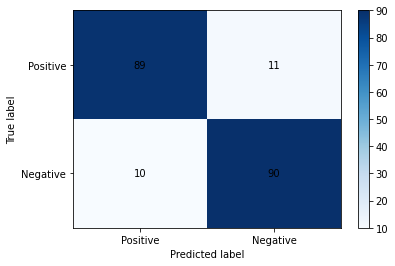

Test loss: 0.019564820826053618 
 Test accuracy: 89.5
------------------------------------------------------------------

 Fold: 1
epoch 0:
Training loss: 0.021883379386530982 
 Training accuracy: 54.666666666666664
Test loss: 0.023144231736660005 
 Test accuracy: 68.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.017952287412352032 
 Training accuracy: 70.11111111111111
Test loss: 0.02238459974527359 
 Test accuracy: 71.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.010576064077516397 
 Training accuracy: 85.27777777777777
Test loss: 0.011865745894610882 
 Test accuracy: 83.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.003398812615260896 
 Training accuracy: 95.77777777777777
Test loss: 0.023122172206640243 
 Test accuracy: 81.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.001071218831348233 
 Tr

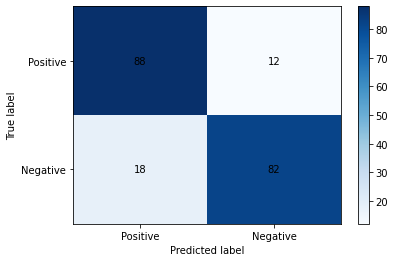

Test loss: 0.038378769755363466 
 Test accuracy: 85.0
------------------------------------------------------------------

 Fold: 2
epoch 0:
Training loss: 0.021812901828024124 
 Training accuracy: 53.44444444444445
Test loss: 0.02354638546705246 
 Test accuracy: 59.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.01917979816595713 
 Training accuracy: 68.11111111111111
Test loss: 0.019287067353725432 
 Test accuracy: 74.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.010438550007012156 
 Training accuracy: 86.22222222222223
Test loss: 0.015016988553106785 
 Test accuracy: 80.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.004646871287582649 
 Training accuracy: 95.11111111111111
Test loss: 0.029698237031698226 
 Test accuracy: 75.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.002772766556687808 
 Trai

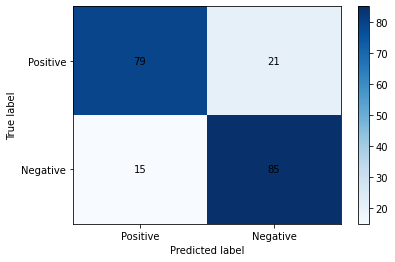

Test loss: 0.0414915007352829 
 Test accuracy: 82.0
------------------------------------------------------------------

 Fold: 3
epoch 0:
Training loss: 0.02168630431095759 
 Training accuracy: 52.55555555555556
Test loss: 0.0221606320142746 
 Test accuracy: 68.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.018722891294293935 
 Training accuracy: 69.11111111111111
Test loss: 0.01662297412753105 
 Test accuracy: 76.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.009830068627165423 
 Training accuracy: 87.1111111111111
Test loss: 0.015470936894416809 
 Test accuracy: 85.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.004036008264972931 
 Training accuracy: 95.72222222222221
Test loss: 0.014137992858886719 
 Test accuracy: 86.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0017390435522732636 
 Training

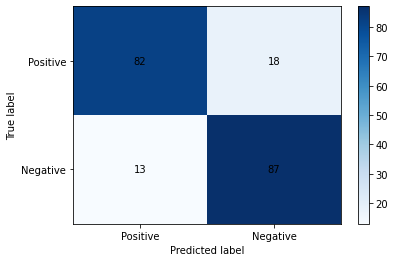

Test loss: 0.029045019317418336 
 Test accuracy: 84.5
------------------------------------------------------------------

 Fold: 4
epoch 0:
Training loss: 0.021365569333235423 
 Training accuracy: 56.222222222222214
Test loss: 0.02267489492893219 
 Test accuracy: 62.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.015806662523084217 
 Training accuracy: 76.0
Test loss: 0.015949544906616212 
 Test accuracy: 78.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.007954493245730797 
 Training accuracy: 90.16666666666666
Test loss: 0.021477906964719296 
 Test accuracy: 83.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.0049152054906719264 
 Training accuracy: 94.05555555555556
Test loss: 0.013058891743421555 
 Test accuracy: 88.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0018328354492000976 
 Training accu

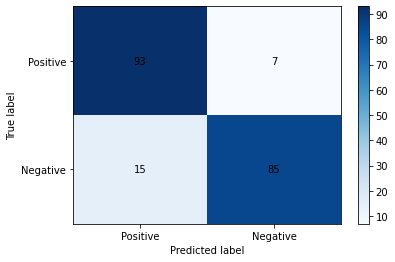

Test loss: 0.03236886042170226 
 Test accuracy: 89.0
------------------------------------------------------------------

 Fold: 5
epoch 0:
Training loss: 0.02172092292043898 
 Training accuracy: 54.61111111111111
Test loss: 0.02052281767129898 
 Test accuracy: 69.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.016530082441038554 
 Training accuracy: 74.44444444444444
Test loss: 0.014078317284584045 
 Test accuracy: 80.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.008446277543488477 
 Training accuracy: 89.16666666666667
Test loss: 0.012742468640208244 
 Test accuracy: 85.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.004130487244369255 
 Training accuracy: 95.66666666666667
Test loss: 0.025652999579906462 
 Test accuracy: 82.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0018536344269200022 
 Trai

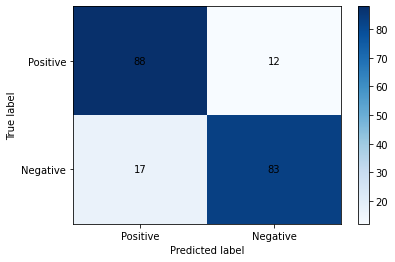

Test loss: 0.030309266690164805 
 Test accuracy: 85.5
------------------------------------------------------------------

 Fold: 6
epoch 0:
Training loss: 0.021912175218264263 
 Training accuracy: 53.0
Test loss: 0.023685273826122285 
 Test accuracy: 50.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.019919913427697288 
 Training accuracy: 62.44444444444445
Test loss: 0.02002165123820305 
 Test accuracy: 72.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.010711374549298651 
 Training accuracy: 85.55555555555556
Test loss: 0.015745364129543304 
 Test accuracy: 82.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.0038752512002570762 
 Training accuracy: 95.61111111111111
Test loss: 0.015868183821439744 
 Test accuracy: 83.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0012644241033639345 
 Training accur

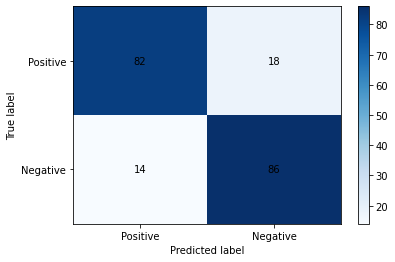

Test loss: 0.03318886011838913 
 Test accuracy: 84.0
------------------------------------------------------------------

 Fold: 7
epoch 0:
Training loss: 0.021590518554051717 
 Training accuracy: 57.55555555555556
Test loss: 0.022369439601898192 
 Test accuracy: 63.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.015703246858384874 
 Training accuracy: 76.22222222222223
Test loss: 0.017265400141477583 
 Test accuracy: 77.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.008534105540149741 
 Training accuracy: 90.11111111111111
Test loss: 0.01672970250248909 
 Test accuracy: 78.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.003109701885841787 
 Training accuracy: 97.0
Test loss: 0.022952538467943668 
 Test accuracy: 84.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0010877424926729873 
 Training accurac

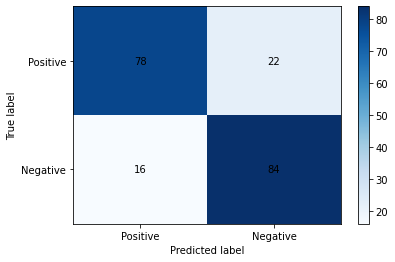

Test loss: 0.03624533295631409 
 Test accuracy: 81.0
------------------------------------------------------------------

 Fold: 8
epoch 0:
Training loss: 0.021210523943106335 
 Training accuracy: 56.55555555555556
Test loss: 0.022674756050109865 
 Test accuracy: 58.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.018485369665755164 
 Training accuracy: 69.05555555555556
Test loss: 0.016953529417514802 
 Test accuracy: 78.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.011091332936452494 
 Training accuracy: 85.11111111111111
Test loss: 0.013599175587296486 
 Test accuracy: 84.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.004203766908289657 
 Training accuracy: 95.5
Test loss: 0.022662631571292877 
 Test accuracy: 79.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0033732440079458884 
 Training accura

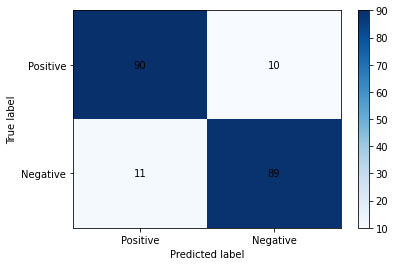

Test loss: 0.021868733689188957 
 Test accuracy: 89.5
------------------------------------------------------------------

 Fold: 9
epoch 0:
Training loss: 0.021041438082853952 
 Training accuracy: 59.55555555555555
Test loss: 0.019260675609111787 
 Test accuracy: 75.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.01381278484231896 
 Training accuracy: 80.33333333333333
Test loss: 0.02024191424250603 
 Test accuracy: 81.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.012123887638250987 
 Training accuracy: 86.8888888888889
Test loss: 0.033760618269443515 
 Test accuracy: 62.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.005019571990188625 
 Training accuracy: 93.66666666666667
Test loss: 0.01836782068014145 
 Test accuracy: 84.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.002358571460030766 
 Traini

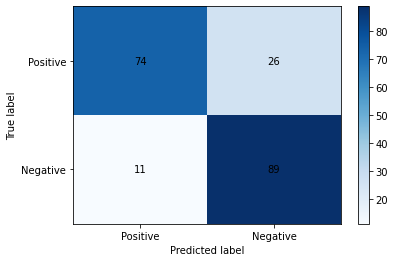

Test loss: 0.03962436586618424 
 Test accuracy: 81.5
------------------------------------------------------------------
Folds statistics:
----------------
 - mean: 85.3 
 - standard deviation: 3.0182776545573144


In [ ]:
# Smaller batch sizes are noisy, this means that they are more regularizing and the
# generalization error will be lower
mean, std = main_cross_validation(main, mr_dataset, mr_embedding_matrix, collate, epochs = 10, batch_size=32)
# 85.6 +- 3.6 using 32 as bsize
# 85.3 +- 3.01
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

#### Removing objective sentences:
Now the BiLSTM with attention will be tested again, but the corpus will have the objective sentences removed.

In [ ]:
# -1 adds the element in the penultimate position (Since flattener should be the last one)
mr_pipeline.add_pipeline_element(ShallowObjectiveSentsRemover(pred), -1)
mr_corpus = MovieReviewsCorpus(mr_pipeline)
mr_embedding_matrix = mr_corpus.get_embedding_matrix(fast_text, 300)
mr_dataset = MovieReviewsDataset(mr_corpus.get_indexed_corpus())

NameError: ignored


 Fold: 0
epoch 0:
Training loss: 0.021512198580635918 
 Training accuracy: 54.333333333333336
Test loss: 0.020475755482912063 
 Test accuracy: 68.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.018359134710497327 
 Training accuracy: 72.27777777777777
Test loss: 0.02865382969379425 
 Test accuracy: 59.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.013037002657850584 
 Training accuracy: 83.11111111111111
Test loss: 0.019275848269462586 
 Test accuracy: 77.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.008900397477878465 
 Training accuracy: 89.61111111111111
Test loss: 0.019483530521392824 
 Test accuracy: 77.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.005363702689452718 
 Training accuracy: 94.44444444444444
Test loss: 0.011931483671069144 
 Test accuracy: 89.5
--------------------------------

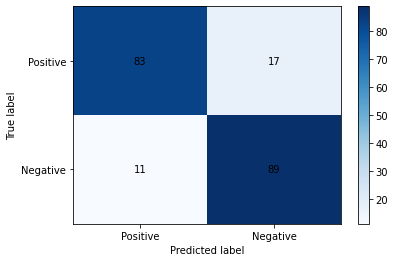

Test loss: 0.02114963620901108 
 Test accuracy: 86.0
------------------------------------------------------------------

 Fold: 1
epoch 0:
Training loss: 0.02187456018394894 
 Training accuracy: 53.94444444444444
Test loss: 0.023464379906654356 
 Test accuracy: 52.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.017155060354206296 
 Training accuracy: 73.44444444444444
Test loss: 0.016608388870954515 
 Test accuracy: 78.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.008748898194171488 
 Training accuracy: 89.33333333333333
Test loss: 0.013796996027231216 
 Test accuracy: 81.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.004057546384994768 
 Training accuracy: 95.38888888888889
Test loss: 0.012784958742558956 
 Test accuracy: 87.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0017148723010905087 
 Tra

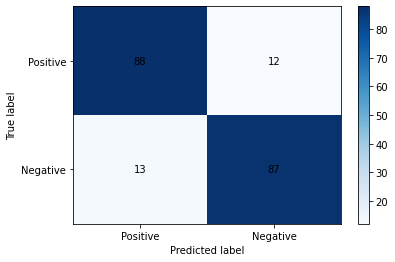

Test loss: 0.027235181331634523 
 Test accuracy: 87.5
------------------------------------------------------------------

 Fold: 2
epoch 0:
Training loss: 0.021950910290082296 
 Training accuracy: 51.61111111111111
Test loss: 0.02369211733341217 
 Test accuracy: 65.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.016686444481213886 
 Training accuracy: 74.55555555555556
Test loss: 0.018010649234056472 
 Test accuracy: 77.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.008143683877877063 
 Training accuracy: 89.88888888888889
Test loss: 0.03213131934404373 
 Test accuracy: 70.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.0043597892278598414 
 Training accuracy: 95.11111111111111
Test loss: 0.012963335290551185 
 Test accuracy: 84.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0017241818068820672 
 Tr

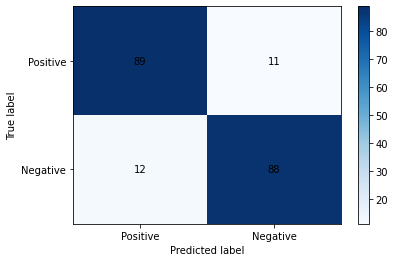

Test loss: 0.026981020346283913 
 Test accuracy: 88.5
------------------------------------------------------------------

 Fold: 3
epoch 0:
Training loss: 0.021915737258063422 
 Training accuracy: 51.83333333333333
Test loss: 0.023735269010066985 
 Test accuracy: 51.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.016819364378849667 
 Training accuracy: 73.44444444444444
Test loss: 0.015889299660921098 
 Test accuracy: 82.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.0092494085451795 
 Training accuracy: 88.61111111111111
Test loss: 0.010131264440715312 
 Test accuracy: 87.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0035442301936240658 
 Training accuracy: 96.61111111111111
Test loss: 0.013833516016602517 
 Test accuracy: 89.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.001285253368680262 
 Tra

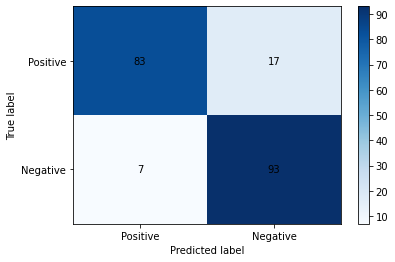

Test loss: 0.030793275088071823 
 Test accuracy: 88.0
------------------------------------------------------------------

 Fold: 4
epoch 0:
Training loss: 0.021164547751347223 
 Training accuracy: 58.27777777777777
Test loss: 0.020057521909475327 
 Test accuracy: 68.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.014611076629824108 
 Training accuracy: 78.55555555555556
Test loss: 0.01610172212123871 
 Test accuracy: 82.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.009056647399233448 
 Training accuracy: 88.88888888888889
Test loss: 0.014292557537555695 
 Test accuracy: 85.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0036052347944738965 
 Training accuracy: 96.5
Test loss: 0.015929975882172584 
 Test accuracy: 87.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0017223764316683324 
 Training accur

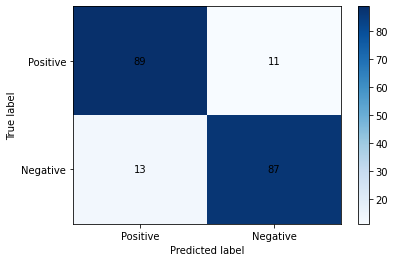

Test loss: 0.029489748403429984 
 Test accuracy: 88.0
------------------------------------------------------------------

 Fold: 5
epoch 0:
Training loss: 0.021657885478602517 
 Training accuracy: 56.05555555555556
Test loss: 0.021052989959716797 
 Test accuracy: 71.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.01637107600768407 
 Training accuracy: 74.6111111111111
Test loss: 0.012585555166006089 
 Test accuracy: 84.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.00783982973338829 
 Training accuracy: 90.94444444444446
Test loss: 0.010431821197271348 
 Test accuracy: 89.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.003384712795054333 
 Training accuracy: 95.94444444444444
Test loss: 0.013906423598527909 
 Test accuracy: 90.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0020637832089172056 
 Trai

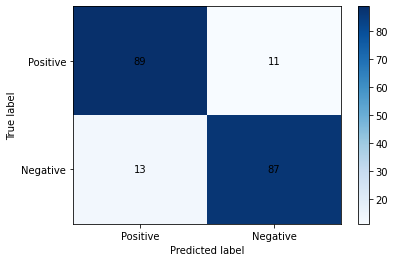

Test loss: 0.02759389013051987 
 Test accuracy: 88.0
------------------------------------------------------------------

 Fold: 6
epoch 0:
Training loss: 0.021477644542853037 
 Training accuracy: 55.55555555555556
Test loss: 0.018684530258178712 
 Test accuracy: 79.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.018360609610875447 
 Training accuracy: 70.77777777777777
Test loss: 0.017935574650764466 
 Test accuracy: 71.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.011168680058585272 
 Training accuracy: 85.61111111111111
Test loss: 0.0183359494805336 
 Test accuracy: 78.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.006131950957286689 
 Training accuracy: 92.11111111111111
Test loss: 0.012026039361953735 
 Test accuracy: 85.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0030714936554431917 
 Trai

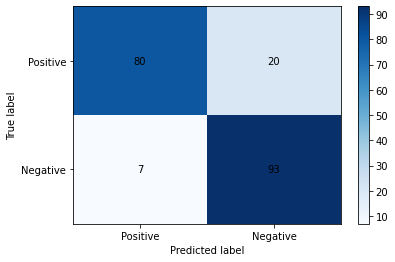

Test loss: 0.021131485775113104 
 Test accuracy: 86.5
------------------------------------------------------------------

 Fold: 7
epoch 0:
Training loss: 0.021745238800843558 
 Training accuracy: 51.888888888888886
Test loss: 0.02338062971830368 
 Test accuracy: 69.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.014364176334606276 
 Training accuracy: 80.44444444444444
Test loss: 0.02512601912021637 
 Test accuracy: 74.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.0058781331694788405 
 Training accuracy: 92.61111111111111
Test loss: 0.012170437350869178 
 Test accuracy: 82.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.002471576234478966 
 Training accuracy: 97.22222222222221
Test loss: 0.023771783262491228 
 Test accuracy: 85.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0008604394108634653 
 T

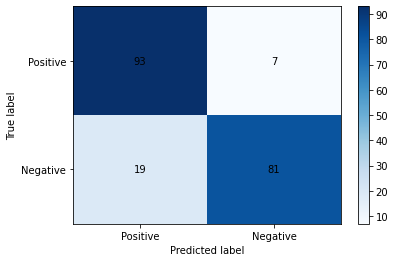

Test loss: 0.018413975574076175 
 Test accuracy: 87.0
------------------------------------------------------------------

 Fold: 9
epoch 0:
Training loss: 0.021261623137527042 
 Training accuracy: 56.777777777777786
Test loss: 0.020759401321411134 
 Test accuracy: 73.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.014065118026402262 
 Training accuracy: 79.77777777777779
Test loss: 0.013643052875995636 
 Test accuracy: 83.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.006726418963323036 
 Training accuracy: 92.5
Test loss: 0.01738941103219986 
 Test accuracy: 83.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0022082057672863204 
 Training accuracy: 98.0
Test loss: 0.015499533861875534 
 Test accuracy: 85.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0010065632814560861 
 Training accuracy: 99.0555

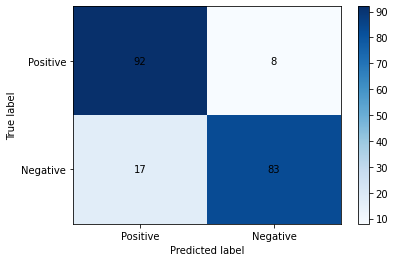

Test loss: 0.019752214103937148 
 Test accuracy: 87.5
------------------------------------------------------------------
Folds statistics:
----------------
 - mean: 87.3 
 - standard deviation: 0.8426149773176358


In [ ]:
mean, std = main_cross_validation(main, mr_dataset, mr_embedding_matrix, collate, epochs = 10, batch_size=32)
# 87.95 +- 1.54
# 87.3 +- 0.84
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

#### LBSA

In [ ]:
LBSA_pipeline = Pipeline(UnderscoreRemover(),
                         CharacterRepetitionRemover(),
                         ApostrophesMerger(),
                         ContractionCleaner(),
                         SpecialCharsCleaner(),
                         )
LBSA_corpus = MovieReviewsCorpusLBSA(LBSA_pipeline)
LBSA_embedding_matrix = LBSA_corpus.get_embedding_matrix(fast_text, 300)
LBSA_dataset = MovieReviewsDatasetLBSA(LBSA_corpus.get_indexed_corpus())

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Coverage of the lexicon: 0.5892331132554596


In [ ]:
mean, std = main_cross_validation(main_LBSA, LBSA_dataset, LBSA_embedding_matrix, collateLBSA, epochs = 10, batch_size=32)
# 86.2 +- 2.21
# 86.1 +- 3
# 86.45 +- 2.65
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")


 Fold: 0
epoch 0:
Training loss: 0.0592666498819987 
 Training accuracy: 49.55555555555556
Test loss: 0.07177372336387634 
 Test accuracy: 50.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.05788864592711131 
 Training accuracy: 50.27777777777778
Test loss: 0.06512533068656921 
 Test accuracy: 50.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.05570763111114502 
 Training accuracy: 49.833333333333336
Test loss: 0.060778762698173526 
 Test accuracy: 70.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.04967145197921329 
 Training accuracy: 75.6111111111111
Test loss: 0.05740067541599274 
 Test accuracy: 80.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.04240316987037659 
 Training accuracy: 89.05555555555556
Test loss: 0.05338296949863434 
 Test accuracy: 78.5
------------------------------------------

In [ ]:
LBSA_pipeline.add_pipeline_element(ShallowObjectiveSentsRemover(pred))
LBSA_corpus = MovieReviewsCorpusLBSA(LBSA_pipeline)
LBSA_embedding_matrix = LBSA_corpus.get_embedding_matrix(fast_text, 300)
LBSA_dataset = MovieReviewsDatasetLBSA(LBSA_corpus.get_indexed_corpus())

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Coverage of the lexicon: 0.6404279317770106


In [ ]:
mean, std = main_cross_validation(main_LBSA, LBSA_dataset, LBSA_embedding_matrix, collateLBSA, epochs = 10, batch_size=32)
# - mean: 88.5 
# - standard deviation: 1.9235384061671346

# 88.7 +- 1.73
# Good Run:
# - mean: 89.35 
# - standard deviation: 1.285496013218244

# Run mapping al Senticnet and sentiwordnet to [0,1]:

print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")


 Fold: 0
epoch 0:
Training loss: 0.040704006022877166 
 Training accuracy: 49.166666666666664
Test loss: 0.04470148384571075 
 Test accuracy: 57.99999999999999
------------------------------------------------------------------
epoch 1:
Training loss: 0.03297456910212835 
 Training accuracy: 78.22222222222223
Test loss: 0.03241988599300385 
 Test accuracy: 85.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.02461487140920427 
 Training accuracy: 93.61111111111111
Test loss: 0.040085752010345456 
 Test accuracy: 78.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.022435347570313346 
 Training accuracy: 97.94444444444444
Test loss: 0.035604115128517154 
 Test accuracy: 88.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.02204880436261495 
 Training accuracy: 99.5
Test loss: 0.03576484739780426 
 Test accuracy: 91.0
-------------------------------------

### Deep Models (Glove 840B Embedding)

In [35]:
global_vectors = GloVe(name='840B', dim=300, cache = "/content/gdrive/My Drive/nlu-project/Embeddings/.vector_cache")

#### BiLSTM

In [160]:
mr_pipeline = Pipeline(UnderscoreRemover(),
                       CharacterRepetitionRemover(),
                       ApostrophesMerger(),
                       ContractionCleaner(),
                       SpecialCharsCleaner()
                      )
mr_corpus = MovieReviewsCorpus(mr_pipeline)
mr_embedding_matrix = mr_corpus.get_embedding_matrix(global_vectors, 300)
mr_dataset = MovieReviewsDataset(mr_corpus.get_indexed_corpus())

In [ ]:
mean, std = main_cross_validation(main_LSTM, mr_dataset, mr_embedding_matrix, collate, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

In [162]:
mr_pipeline.add_pipeline_element(ShallowObjectiveSentsRemover(pred), -1)
mr_corpus = MovieReviewsCorpus(mr_pipeline)
mr_embedding_matrix = mr_corpus.get_embedding_matrix(global_vectors, 300)
mr_dataset = MovieReviewsDataset(mr_corpus.get_indexed_corpus())

In [ ]:
mean, std = main_cross_validation(main_LSTM, mr_dataset, mr_embedding_matrix, collate, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

#### BiLSTM with attention

In [ ]:
mr_pipeline = Pipeline(UnderscoreRemover(),
                       CharacterRepetitionRemover(),
                       ApostrophesMerger(),
                       ContractionCleaner(),
                       SpecialCharsCleaner()
                      )
mr_corpus = MovieReviewsCorpus(mr_pipeline)
mr_embedding_matrix = mr_corpus.get_embedding_matrix(global_vectors, 300)
mr_dataset = MovieReviewsDataset(mr_corpus.get_indexed_corpus())


 Fold: 0
epoch 0:
Training loss: 0.020321167409420013 
 Training accuracy: 60.77777777777777
Test loss: 0.023042260408401488 
 Test accuracy: 69.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.014085113869773017 
 Training accuracy: 81.55555555555556
Test loss: 0.01912254549562931 
 Test accuracy: 70.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.008410132348847885 
 Training accuracy: 89.27777777777777
Test loss: 0.012351328730583191 
 Test accuracy: 85.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.0053613258918954266 
 Training accuracy: 94.88888888888889
Test loss: 0.035188176929950715 
 Test accuracy: 72.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.003979470030495173 
 Training accuracy: 95.83333333333334
Test loss: 0.0215014835447073 
 Test accuracy: 84.5
----------------------------------

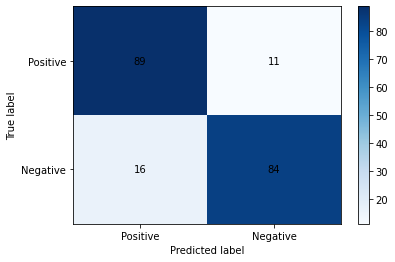

Test loss: 0.02455816313624382 
 Test accuracy: 86.5
------------------------------------------------------------------

 Fold: 1
epoch 0:
Training loss: 0.019837809238168927 
 Training accuracy: 63.388888888888886
Test loss: 0.01836673855781555 
 Test accuracy: 75.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.011563312601712014 
 Training accuracy: 85.5
Test loss: 0.010784861631691456 
 Test accuracy: 86.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.006340731261815462 
 Training accuracy: 93.0
Test loss: 0.010355805531144142 
 Test accuracy: 89.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0037828627684050138 
 Training accuracy: 96.22222222222221
Test loss: 0.01054690359160304 
 Test accuracy: 90.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0017524722720554564 
 Training accuracy: 98.277777

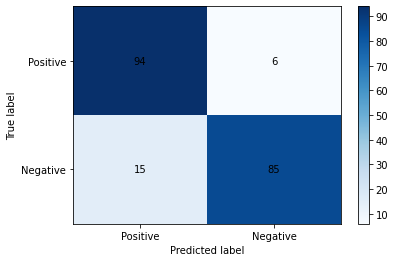

Test loss: 0.021038930118083953 
 Test accuracy: 89.5
------------------------------------------------------------------

 Fold: 2
epoch 0:
Training loss: 0.021639005409346688 
 Training accuracy: 55.77777777777778
Test loss: 0.023622166514396668 
 Test accuracy: 58.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.014594023931357596 
 Training accuracy: 77.61111111111111
Test loss: 0.014611151665449143 
 Test accuracy: 83.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.007041634888284736 
 Training accuracy: 91.77777777777779
Test loss: 0.016764590945094825 
 Test accuracy: 79.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.0038979906108902976 
 Training accuracy: 96.11111111111111
Test loss: 0.013755927458405495 
 Test accuracy: 87.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0018991607058948528 
 

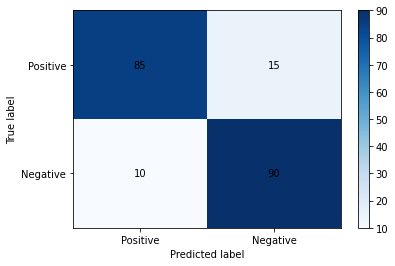

Test loss: 0.026876446902751924 
 Test accuracy: 87.5
------------------------------------------------------------------

 Fold: 3
epoch 0:
Training loss: 0.020466877188947467 
 Training accuracy: 61.44444444444444
Test loss: 0.020734596252441406 
 Test accuracy: 69.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.015118358242842887 
 Training accuracy: 77.38888888888889
Test loss: 0.027674021124839784 
 Test accuracy: 73.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.010418376113391584 
 Training accuracy: 86.44444444444444
Test loss: 0.013598853200674057 
 Test accuracy: 85.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.004593763415598207 
 Training accuracy: 95.22222222222221
Test loss: 0.009734878987073899 
 Test accuracy: 87.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0020161012627391353 
 T

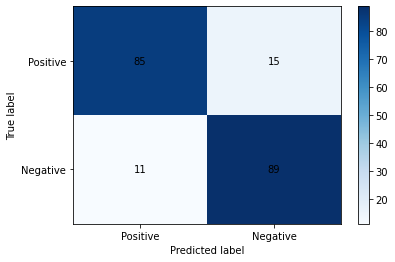

Test loss: 0.027171436518983683 
 Test accuracy: 87.0
------------------------------------------------------------------

 Fold: 4
epoch 0:
Training loss: 0.02066038254234526 
 Training accuracy: 57.88888888888889
Test loss: 0.023110405802726747 
 Test accuracy: 63.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.015411723670032289 
 Training accuracy: 76.88888888888889
Test loss: 0.014417345374822617 
 Test accuracy: 82.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.007268487695190642 
 Training accuracy: 91.55555555555556
Test loss: 0.014530240893363952 
 Test accuracy: 84.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.003965391370260881 
 Training accuracy: 95.27777777777777
Test loss: 0.0159903646633029 
 Test accuracy: 87.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.002145202567270543 
 Train

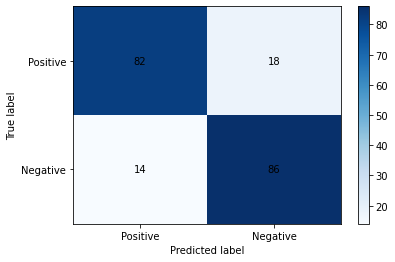

Test loss: 0.02696590650448343 
 Test accuracy: 84.0
------------------------------------------------------------------

 Fold: 5
epoch 0:
Training loss: 0.021083188503980638 
 Training accuracy: 57.611111111111114
Test loss: 0.02333957076072693 
 Test accuracy: 57.49999999999999
------------------------------------------------------------------
epoch 1:
Training loss: 0.013983973306086328 
 Training accuracy: 80.61111111111111
Test loss: 0.010793446302413941 
 Test accuracy: 87.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.007268247409827179 
 Training accuracy: 91.72222222222223
Test loss: 0.009224915923550726 
 Test accuracy: 87.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.003453413515041272 
 Training accuracy: 96.72222222222221
Test loss: 0.014212841838598252 
 Test accuracy: 89.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.00239601116

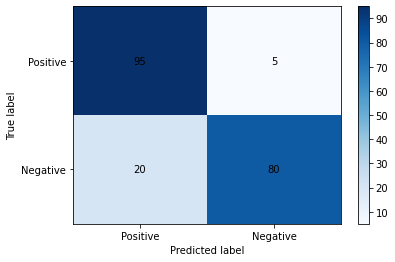

Test loss: 0.02269752469697778 
 Test accuracy: 87.5
------------------------------------------------------------------

 Fold: 6
epoch 0:
Training loss: 0.01995615396234724 
 Training accuracy: 61.88888888888889
Test loss: 0.01742272526025772 
 Test accuracy: 81.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.012146635974446932 
 Training accuracy: 82.61111111111111
Test loss: 0.016380982100963594 
 Test accuracy: 84.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.007023760301785337 
 Training accuracy: 92.22222222222223
Test loss: 0.0159126877784729 
 Test accuracy: 83.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0038747352309938935 
 Training accuracy: 96.38888888888889
Test loss: 0.013941770177334547 
 Test accuracy: 87.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0019447834498067904 
 Train

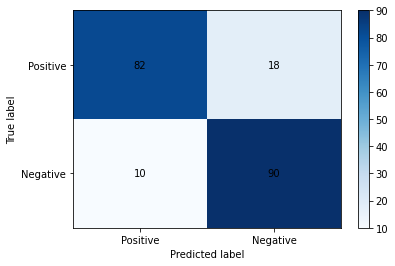

Test loss: 0.02937154084444046 
 Test accuracy: 86.0
------------------------------------------------------------------

 Fold: 7
epoch 0:
Training loss: 0.02062764225734605 
 Training accuracy: 58.05555555555556
Test loss: 0.019125311821699142 
 Test accuracy: 72.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.013605132889416482 
 Training accuracy: 81.66666666666667
Test loss: 0.013810717612504958 
 Test accuracy: 83.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.0061224723648693824 
 Training accuracy: 92.44444444444444
Test loss: 0.016481806114315985 
 Test accuracy: 84.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.0031056625384048354 
 Training accuracy: 96.22222222222221
Test loss: 0.01945370264351368 
 Test accuracy: 88.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0016146521356939856 
 Tr

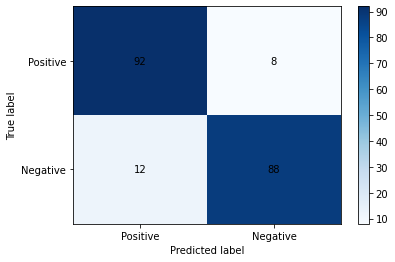

Test loss: 0.030264978855848314 
 Test accuracy: 90.0
------------------------------------------------------------------

 Fold: 8
epoch 0:
Training loss: 0.02070161130693224 
 Training accuracy: 60.77777777777777
Test loss: 0.018465274274349214 
 Test accuracy: 74.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.016352811497118737 
 Training accuracy: 76.83333333333333
Test loss: 0.014870824962854386 
 Test accuracy: 81.5
------------------------------------------------------------------
epoch 2:
Training loss: 0.01022295674516095 
 Training accuracy: 87.16666666666667
Test loss: 0.011607243195176125 
 Test accuracy: 86.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0048812451115291975 
 Training accuracy: 94.55555555555556
Test loss: 0.010265503423288464 
 Test accuracy: 87.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0033153450002686843 
 Tr

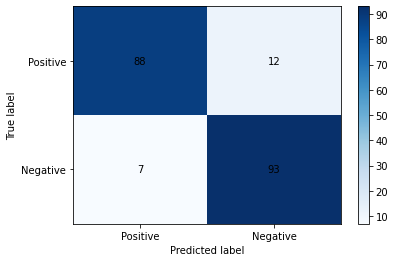

Test loss: 0.013525174375390634 
 Test accuracy: 90.5
------------------------------------------------------------------

 Fold: 9
epoch 0:
Training loss: 0.02171696338388655 
 Training accuracy: 54.72222222222223
Test loss: 0.02121826261281967 
 Test accuracy: 72.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.014724689970413844 
 Training accuracy: 78.05555555555556
Test loss: 0.013459569588303567 
 Test accuracy: 84.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.007105408244662815 
 Training accuracy: 92.0
Test loss: 0.023887740671634673 
 Test accuracy: 72.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.004119300754068213 
 Training accuracy: 94.94444444444444
Test loss: 0.014638079218566418 
 Test accuracy: 86.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.0016095680043185388 
 Training accurac

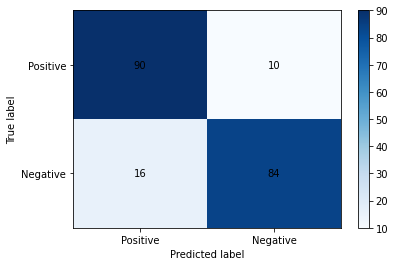

Test loss: 0.03099805936217308 
 Test accuracy: 87.0
------------------------------------------------------------------
Folds statistics:
----------------
 - mean: 87.5 
 - standard deviation: 1.760681686165901


In [163]:
mean, std = main_cross_validation(main, mr_dataset, mr_embedding_matrix, collate, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

In [ ]:
mr_pipeline.add_pipeline_element(ShallowObjectiveSentsRemover(pred), -1)
mr_corpus = MovieReviewsCorpus(mr_pipeline)
mr_embedding_matrix = mr_corpus.get_embedding_matrix(fast_text, 300)
mr_dataset = MovieReviewsDataset(mr_corpus.get_indexed_corpus())

In [ ]:
mean, std = main_cross_validation(main, mr_dataset, mr_embedding_matrix, collate, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

#### LBSA

In [149]:
LBSA_pipeline = Pipeline(UnderscoreRemover(),
                         CharacterRepetitionRemover(),
                         ApostrophesMerger(),
                         ContractionCleaner(),
                         SpecialCharsCleaner(),
                         )
LBSA_corpus = MovieReviewsCorpusLBSA(LBSA_pipeline)
LBSA_embedding_matrix = LBSA_corpus.get_embedding_matrix(global_vectors, 300)
LBSA_dataset = MovieReviewsDatasetLBSA(LBSA_corpus.get_indexed_corpus())

Coverage of the lexicon: 0.3351701371254444


In [ ]:
mean, std = main_cross_validation(main_LBSA, LBSA_dataset, LBSA_embedding_matrix, collateLBSA, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

In [150]:
LBSA_pipeline.add_pipeline_element(ShallowObjectiveSentsRemover(pred))
LBSA_corpus = MovieReviewsCorpusLBSA(LBSA_pipeline)
LBSA_embedding_matrix = LBSA_corpus.get_embedding_matrix(global_vectors, 300)
LBSA_dataset = MovieReviewsDatasetLBSA(LBSA_corpus.get_indexed_corpus())

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Coverage of the lexicon: 0.3956659944628636


In [159]:
mean, std = main_cross_validation(main_LBSA, LBSA_dataset, LBSA_embedding_matrix, collateLBSA, epochs = 10, batch_size=32)
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")


 Fold: 0
epoch 0:
Training loss: 0.028956237766477797 
 Training accuracy: 52.166666666666664
Test loss: 0.03167926639318466 
 Test accuracy: 71.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.020201681902011236 
 Training accuracy: 81.88888888888889
Test loss: 0.017615165263414383 
 Test accuracy: 91.0
------------------------------------------------------------------
epoch 2:
Training loss: 0.012195981608496772 
 Training accuracy: 93.88888888888889
Test loss: 0.016749499440193175 
 Test accuracy: 88.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.009609900108642048 
 Training accuracy: 97.88888888888889
Test loss: 0.020257920175790787 
 Test accuracy: 90.0
------------------------------------------------------------------
epoch 4:
Training loss: 0.008630612467726072 
 Training accuracy: 99.5
Test loss: 0.02053904324769974 
 Test accuracy: 91.0
----------------------------------------------

## Result analysis:

Train a netwrok from scratch

In [36]:
mr_pipeline = Pipeline(UnderscoreRemover(),
                       CharacterRepetitionRemover(),
                       ApostrophesMerger(),
                       ContractionCleaner(),
                       SpecialCharsCleaner(),
                       ShallowObjectiveSentsRemover(pred)
                      )
mr_corpus = MovieReviewsCorpus(mr_pipeline)
mr_embedding_matrix = mr_corpus.get_embedding_matrix(global_vectors, 300)
mr_dataset = MovieReviewsDataset(mr_corpus.get_indexed_corpus())

epoch 0:
Training loss: 0.020769996512681247 
 Training accuracy: 57.1875
Test loss: 0.017563230469822885 
 Test accuracy: 78.5
------------------------------------------------------------------
epoch 1:
Training loss: 0.013863604804500938 
 Training accuracy: 79.375
Test loss: 0.012184925265610219 
 Test accuracy: 83.75
------------------------------------------------------------------
epoch 2:
Training loss: 0.006970644993707538 
 Training accuracy: 92.5
Test loss: 0.009749482292681933 
 Test accuracy: 88.0
------------------------------------------------------------------
epoch 3:
Training loss: 0.0026464064231549855 
 Training accuracy: 97.0
Test loss: 0.011297157686203717 
 Test accuracy: 88.75
------------------------------------------------------------------
epoch 4:
Training loss: 0.0013745975535493927 
 Training accuracy: 98.5625
Test loss: 0.012979472130537033 
 Test accuracy: 90.75
------------------------------------------------------------------
epoch 5:
Training loss: 0.0

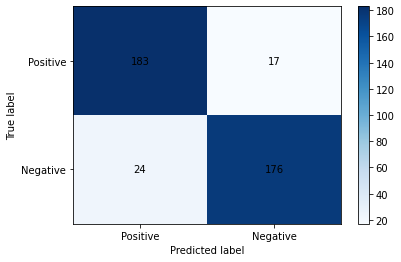

Test loss: 0.025215624179691077 
 Test accuracy: 89.75
------------------------------------------------------------------


In [37]:
if torch.cuda.is_available():
  device = 'cuda'
train_indexes = [i*1000 + j for i in range(2) for j in range(800)]
test_indexes = [i*1000 + j for i in range(2) for j in range(800,1000)]


train_sampler = SubsetRandomSampler(train_indexes)
test_sampler = SubsetRandomSampler(test_indexes)

train_loader = DataLoader(mr_dataset, batch_size = 32, sampler = train_sampler,
                          collate_fn = collate, pin_memory=True)
test_loader = DataLoader(mr_dataset, batch_size = 32, sampler = test_sampler,
                        collate_fn = collate, pin_memory = True)

# Important that we keep a trained network
net = BiLSTMAttention(mr_embedding_matrix)
test_accuracy = main(train_loader, test_loader, mr_embedding_matrix, device, 10, net)

In [38]:
def indexed_corpus(corpus, vocab):
  # I don't care about labels since I'm not backpropagating and I am only interested in attention map
  labels = [1 for i in range(len(corpus))]
  new_vocab = {}
  for idx, key in enumerate(vocab.keys()):
    new_vocab[key] = idx

  indexed_corpus = [torch.tensor([torch.tensor(new_vocab[w], dtype=torch.int32) for w in doc]) for doc in corpus]
  return corpus, indexed_corpus, labels

In [80]:
for idxdoc, doc in enumerate(pos):
  for idxsent, sent in enumerate(doc):
    for word in sent:
      if word == "beautiful":
        print(f"doc: {idxdoc} \n sent: {idxsent}")

doc: 3 
 sent: 4
doc: 28 
 sent: 11
doc: 33 
 sent: 19
doc: 33 
 sent: 22
doc: 35 
 sent: 19
doc: 53 
 sent: 6
doc: 60 
 sent: 36
doc: 66 
 sent: 0
doc: 78 
 sent: 1
doc: 83 
 sent: 19
doc: 83 
 sent: 22
doc: 86 
 sent: 33
doc: 87 
 sent: 39
doc: 87 
 sent: 40
doc: 94 
 sent: 23
doc: 95 
 sent: 0
doc: 95 
 sent: 7
doc: 95 
 sent: 15
doc: 95 
 sent: 23
doc: 95 
 sent: 27
doc: 113 
 sent: 25
doc: 129 
 sent: 1
doc: 129 
 sent: 3
doc: 129 
 sent: 12
doc: 129 
 sent: 16
doc: 133 
 sent: 1
doc: 133 
 sent: 12
doc: 143 
 sent: 7
doc: 144 
 sent: 0
doc: 160 
 sent: 26
doc: 163 
 sent: 27
doc: 167 
 sent: 2
doc: 167 
 sent: 17
doc: 167 
 sent: 37
doc: 169 
 sent: 17
doc: 169 
 sent: 27
doc: 169 
 sent: 52
doc: 171 
 sent: 23
doc: 204 
 sent: 8
doc: 228 
 sent: 23
doc: 237 
 sent: 9
doc: 245 
 sent: 2
doc: 247 
 sent: 26
doc: 248 
 sent: 29
doc: 258 
 sent: 19
doc: 263 
 sent: 2
doc: 264 
 sent: 6
doc: 264 
 sent: 25
doc: 269 
 sent: 36
doc: 275 
 sent: 8
doc: 283 
 sent: 11
doc: 301 
 sent: 23

In [88]:
# I can get training instances just to see attention map
# reduced = mr_corpus.get_subset_indexed_corpus([0, 1000])
some_sentences = mr_pipeline([pos[3]])
some_sentences = some_sentences[0][:5]
reduced = indexed_corpus(some_sentences, mr_corpus.vocab)
reduced_ds = MovieReviewsDataset((reduced[1], reduced[2]))
reduced_dl = DataLoader(reduced_ds, batch_size = 1, collate_fn = collate, pin_memory = True)

In [89]:
net.eval()

with torch.no_grad():
  att = []
  for batch_idx, (inputs, targets, _) in enumerate(reduced_dl):
    inputs = inputs.to(device)
    targets = targets.to(device)
    in_size = targets.size(dim=0)

    outputs, attention = net(inputs)
    att.append(attention)

In [90]:
def plot_attention(attention, sentence, filename = None):
  fig, ax = plt.subplots()
  im = ax.imshow(attention.reshape(-1,1).T, cmap='viridis', aspect='auto', origin='lower')
  ax.set_xticks(range(len(sentence)))
  ax.set_xticklabels(sentence, rotation=90)
  cbar = fig.colorbar(im)
  cbar.set_label("Attention Weight")
  ax.set_yticks([])
  ax.set_aspect("equal")
  # plt.savefig(filename)

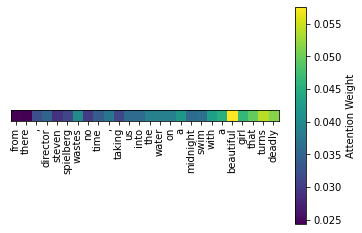

In [102]:
att_arr = att[2][0].cpu().detach().numpy()
plot_attention(att_arr,reduced[0][2])

In [145]:
LBSA_pipeline = Pipeline(UnderscoreRemover(),
                         CharacterRepetitionRemover(),
                         ApostrophesMerger(),
                         ContractionCleaner(),
                         SpecialCharsCleaner(),
                         )
LBSA_pipeline.add_pipeline_element(ShallowObjectiveSentsRemover(pred))
LBSA_corpus = MovieReviewsCorpusLBSA(LBSA_pipeline)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Coverage of the lexicon: 0.3956659944628636


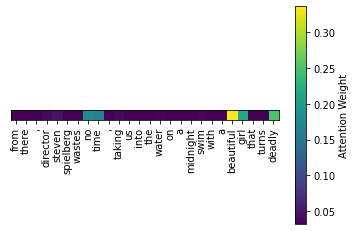

In [146]:
gold_word = LBSA_corpus.wl_gold_av[1003][2]
plot_attention(gold_word,reduced[0][2])

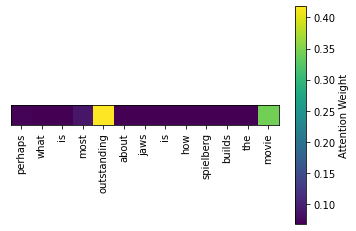

In [147]:
gold_word = LBSA_corpus.wl_gold_av[1003][4]
plot_attention(gold_word,reduced[0][4])

# Subjectivity Detection

In [ ]:
from torch.utils.data import Dataset
from torchtext.vocab import GloVe

class SubjectivityDataset(Dataset):
  def __init__(self, raw_dataset):
    super(SubjectivityDataset, self).__init__()
    self.corpus = raw_dataset[0]
    self.targets = raw_dataset[1]

  def __len__(self):
    return len(self.corpus)
  
  def __getitem__(self, index):
    item = self.corpus[index]
    label = self.targets[index]
    return (item, label)

In [ ]:
pipeline_sub = pipeline = Pipeline(UnderscoreRemoverFlat(),
                                   CharacterRepetitionRemoverFlat(),
                                   ContractionCleanerFlat(),
                                   SpecialCharsCleanerFlat(),
                                  )
corpus_subj = SubjectivityCorpus(pipeline)
corpus_subj.embed_vocab(corpus.vocab)

In [ ]:
dataset_subj = SubjectivityDataset(corpus_subj.get_indexed_corpus())
train_loader_subj, test_loader_subj = get_data(128, dataset_subj, collate)

In [ ]:
embedding_matrix_subj = corpus_subj.get_embedding_matrix(global_vectors, 300)

In [ ]:
_, net_obj= main(train_loader_subj, test_loader_subj, embedding_matrix_subj, device = "cuda", epochs = 10)

# print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")

## Try to use trained subjectivity in order to improve polarity

In [ ]:
def collate_testing(X, device = "cuda"):
  if type(X) == list:
    X = torch.tensor(X)
  if len(X.size()) == 1:
    X = torch.unsqueeze(X, 0)
  
  X_tensor = X.to(device)
  X_final = pack_padded_sequence(X_tensor, torch.tensor([1]), batch_first=True)
  return X_final


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from nltk.sentiment.util import mark_negation

class ObjectiveSentsRemover(PipelineElement):
  def __init__(self, net = None, vocab = None):
    """
    Parameters
    ----------
    net
      Already trained network in order to classify objective sentences
    """
    super(ObjectiveSentsRemover, self).__init__()
    if net == None:
      raise TypeError("Network cannot be None-type")
    self.net = net
    self.vocab = vocab
  
  def _indexed_corpus(self, corpus):
    indexed_corpus = []
    for doc in corpus:
      new_doc = []
      for sent in doc:
        new_sent = []
        for word in sent:
          new_sent.append(self.vocab[word])
        new_doc.append(new_sent)
      indexed_corpus.append(new_doc)
    return indexed_corpus


  def remove_objective_sents(self, corpus):
    indexed_corpus = self._indexed_corpus(corpus)
    print(len(corpus[0]))
    with torch.no_grad():
      self.net.eval()
      # I want to keep the sentence if it is subjective i.e. when result of classification = 1
      res = [[corpus[doc_idx][sent_idx] for sent_idx, sent in enumerate(doc) if self.net(collate_testing(sent))[0].max(dim = 1)[1].item() == 1]
             for doc_idx, doc in enumerate(indexed_corpus)]
      print(len(res[0]))
    return res
  
  def __call__(self, corpus):
    return self.remove_objective_sents(corpus)

class ShallowObjectiveSentsRemover(PipelineElement):
  def __init__(self, threshold = .5, clf = MultinomialNB, trained = False):
    self.vectorizer = CountVectorizer()
    self.classifier = clf()
    if not trained:
      self.best_estimator = self._train()
    else:
      self.best_estimator = self.classifier
  
  def _train(self):
    subj = [sent for sent in subjectivity.sents(categories = 'subj')]
    obj = [sent for sent in subjectivity.sents(categories = 'obj')]

    corpus = [self.neg_marking_list2str(d) for d in subj] + [self.neg_marking_list2str(d) for d in obj]
    vectors = self.vectorizer.fit_transform(corpus)
    labels = np.array([1] * len(subj) + [0] * len(obj))
    scores = cross_validate(self.classifier, vectors, labels, cv=StratifiedKFold(n_splits=10) , scoring=['accuracy'], return_estimator=True)
    estimator = scores["estimator"][scores["test_accuracy"].argmax()]
    return estimator

  def neg_marking_list2str(self, sent):
    # takes the doc and produces a single list
    # negates the whole document
    negated_doc = mark_negation(sent, double_neg_flip=True)
    return " ".join([w for w in negated_doc])
    

  def remove_objective_sents(self, corpus):
    transformed_corpus = [[self.vectorizer.transform([self.neg_marking_list2str(sent)]) for sent in doc] for doc in corpus]
    print(len(corpus[0]))
    res = [[corpus[doc_idx][sent_idx] for sent_idx, sent in enumerate(doc) if self.best_estimator.predict(sent).item()]
           for doc_idx, doc in enumerate(transformed_corpus)]
    print(len(res[0]))
    return res
  
  def __call__(self, corpus):
    return self.remove_objective_sents(corpus)


In [ ]:
pipeline = Pipeline(UnderscoreRemover(),
                    CharacterRepetitionRemover(),
                    ApostrophesMerger(),
                    ContractionCleaner(),
                    SpecialCharsCleaner(),
                    ShallowObjectiveSentsRemover(),
                    )
corpus = MovieReviewsCorpusLBSA(pipeline)
# 22

35
27


In [ ]:
embedding_matrix = corpus.get_embedding_matrix(global_vectors, 300)
dataset = MovieReviewsDatasetLBSA(corpus)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [ ]:
# 20 epochs because of the warmup
mean, std = main_cross_validation(main_LBSA, dataset, embedding_matrix, collateLBSA, epochs = 15)
## 88.65 +- 1.24 no residual neither batchnorm
## 89.15 +- 2.16             Residual with reg = False
print(f"Folds statistics:\n----------------\n - mean: {mean} \n - standard deviation: {std}")


 Fold: 0
epoch 0:
Training loss: 0.007959709366162618 
 Training accuracy: 61.05555555555555
Test loss: 0.009188937544822693 
 Test accuracy: 50.0
------------------------------------------------------------------
epoch 1:
Training loss: 0.005274999472830031 
 Training accuracy: 78.38888888888889
Test loss: 0.00855442076921463 
 Test accuracy: 56.49999999999999
------------------------------------------------------------------
epoch 2:
Training loss: 0.003910372091664208 
 Training accuracy: 89.77777777777777
Test loss: 0.0074517691135406496 
 Test accuracy: 85.5
------------------------------------------------------------------
epoch 3:
Training loss: 0.002459457086192237 
 Training accuracy: 96.38888888888889
Test loss: 0.0054387211799621586 
 Test accuracy: 84.5
------------------------------------------------------------------
epoch 4:
Training loss: 0.0018047150638368394 
 Training accuracy: 98.83333333333333
Test loss: 0.0091081303358078 
 Test accuracy: 79.0
-------------------

KeyboardInterrupt: ignored